# **Phase 1: Check and Install Libraries/Dependecies**

In [77]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  96
  On-line CPU(s) list:   0-95
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  24
    Socket(s):           2
    Stepping:            3
    BogoMIPS:            4000.35
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowp

In [78]:
!pip install --upgrade scikit-learn imbalanced-learn
!pip install shap
!pip install optuna

  Using cached scikit_learn-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [79]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint as pp
import time
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pytz
from datetime import datetime, timezone

warnings.filterwarnings('ignore')

In [80]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [81]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# **Phase 2: Load & Clean Data**

In [82]:
# Enhanced IoT and Network Data Processing Script with Conditional Malaysian Timezone Support

# Path to the dataset directory
data_dir = '/kaggle/input/iotdigitaltwin/'
print("Loading data files...")

# Find all IoT and Network files
iot_files = glob.glob(os.path.join(data_dir, 'iot_*.csv'))  
network_files = glob.glob(os.path.join(data_dir, 'network_*.csv'))  
print(f"Found {len(iot_files)} IoT files")
print(f"Found {len(network_files)} Network files")

# Configuration
TIMESTAMP_COL = 'timestamp'
MALAYSIAN_TZ = 'Asia/Kuala_Lumpur'

def standardize_timestamp(df, filename, dataset_type):
    """
    Enhanced timestamp standardization with conditional Malaysian timezone conversion
    - Network datasets: Convert from UTC to Malaysian Time
    - IoT datasets: Keep as-is (already in Malaysian Time)
    """
    print(f"  Processing timestamps for {filename} ({dataset_type})")
    
    # Check what timestamp columns exist
    timestamp_candidates = ['timestamp', 'ts']
    found_col = None
    
    for col in timestamp_candidates:
        if col in df.columns:
            found_col = col
            break
    
    if found_col is None:
        print(f"    WARNING: No timestamp column found in {filename}")
        return None
    
    print(f"    Found timestamp column: {found_col}")
    
    # Get sample value to determine format
    sample_val = df[found_col].dropna().iloc[0] if not df[found_col].dropna().empty else None
    
    if sample_val is None:
        print(f"    WARNING: No valid timestamp values in {filename}")
        return None
    
    print(f"    Sample value: {sample_val} (type: {type(sample_val)})")
    
    try:
        # Check if already datetime
        if pd.api.types.is_datetime64_any_dtype(df[found_col]):
            print(f"    Already in datetime format")
            df[TIMESTAMP_COL] = df[found_col]
        
        # Handle string datetime
        elif isinstance(sample_val, str):
            print(f"    Converting string to datetime")
            df[TIMESTAMP_COL] = pd.to_datetime(df[found_col], errors='coerce')
        
        # Handle numeric timestamps (Unix format)
        else:
            # Determine if seconds or milliseconds
            if sample_val > 1e12:  # Milliseconds
                print(f"    Converting from Unix milliseconds")
                df[TIMESTAMP_COL] = pd.to_datetime(df[found_col], unit='ms', errors='coerce')
            elif sample_val > 1e9:  # Seconds  
                print(f"    Converting from Unix seconds")
                df[TIMESTAMP_COL] = pd.to_datetime(df[found_col], unit='s', errors='coerce')
            else:
                print(f"    Assuming Unix seconds format")
                df[TIMESTAMP_COL] = pd.to_datetime(df[found_col], unit='s', errors='coerce')
        
        # CONDITIONAL TIMEZONE CONVERSION BASED ON DATASET TYPE
        if dataset_type == 'network':
            print(f"    Network dataset: Converting from UTC to Malaysian Time")
            # Convert from UTC to Malaysian Time (UTC+8)
            if df[TIMESTAMP_COL].dt.tz is None:
                # If timezone-naive, assume UTC and localize
                df[TIMESTAMP_COL] = df[TIMESTAMP_COL].dt.tz_localize('UTC')
                print(f"    Localized to UTC timezone")
            
            # Convert to Malaysian Time
            df[TIMESTAMP_COL] = df[TIMESTAMP_COL].dt.tz_convert(MALAYSIAN_TZ)
            print(f"    Converted to Malaysian Time ({MALAYSIAN_TZ})")
            
            # Convert to timezone-naive Malaysian Time for easier processing
            df[TIMESTAMP_COL] = df[TIMESTAMP_COL].dt.tz_localize(None)
            print(f"    Converted to timezone-naive Malaysian Time")
            
        elif dataset_type == 'iot':
            print(f"    IoT dataset: Keeping original timestamp (already Malaysian Time)")
            # For IoT datasets, just ensure timezone-naive for consistency
            if df[TIMESTAMP_COL].dt.tz is not None:
                df[TIMESTAMP_COL] = df[TIMESTAMP_COL].dt.tz_localize(None)
                print(f"    Removed timezone info for consistency")
        
        # Remove original ts column if different from timestamp
        if found_col == 'ts' and 'ts' in df.columns:
            df = df.drop(columns=['ts'])
            print(f"    Removed original 'ts' column")
        
        # Verify conversion worked
        null_timestamps = df[TIMESTAMP_COL].isnull().sum()
        if null_timestamps > 0:
            print(f"    WARNING: {null_timestamps} timestamps could not be converted")
            # Remove rows with null timestamps
            df = df.dropna(subset=[TIMESTAMP_COL])
            print(f"    Removed {null_timestamps} rows with invalid timestamps")
        
        if dataset_type == 'network':
            print(f"    ✓ Timestamp standardized (UTC→MYT): {df[TIMESTAMP_COL].min()} to {df[TIMESTAMP_COL].max()}")
        else:
            print(f"    ✓ Timestamp standardized (MYT): {df[TIMESTAMP_COL].min()} to {df[TIMESTAMP_COL].max()}")
        
    except Exception as e:
        print(f"    ERROR converting timestamps: {e}")
        return None
    
    return df

def load_and_prepare_dataset(file_path, dataset_type):
    """Enhanced dataset loading with conditional timezone handling"""
    filename = os.path.basename(file_path)
    print(f"\nLoading {filename}...")
    
    try:
        # Load dataset with optimized memory usage
        df = pd.read_csv(file_path, low_memory=False)
        print(f"  Initial shape: {df.shape}")
        
        # Check for empty dataset
        if df.empty:
            print(f"  WARNING: Empty dataset")
            return None
        
        # Standardize timestamp with dataset type info
        df = standardize_timestamp(df, filename, dataset_type)
        if df is None:
            return None
        
        # Add dataset metadata
        if dataset_type == 'network':
            # Extract attack type from filename
            attack_type = filename.replace('network_labeled_', '').replace('.csv', '')
            df['type'] = attack_type
            df['label'] = 1 if attack_type != 'normal' else 0
            print(f"  Attack type: {attack_type}")
        
        elif dataset_type == 'iot':
            # Add prefix to avoid column conflicts
            prefix = os.path.splitext(filename)[0].replace('iot_', '').replace('digital', 'iot_digital')
            columns_to_rename = [col for col in df.columns if col != TIMESTAMP_COL]
            df = df.rename(columns={col: f"{prefix}_{col}" for col in columns_to_rename})
        
        # Sort by timestamp for efficient merging
        df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
        
        print(f"  ✓ Processed: {df.shape}")
        return df
        
    except Exception as e:
        print(f"  ✗ Error processing {filename}: {e}")
        return None

def merge_iot_datasets_by_timestamp(dataframes, tolerance='1min'):
    """Enhanced IoT datasets merging with better error handling"""
    if not dataframes:
        print("No IoT datasets to merge")
        return pd.DataFrame()
    
    if len(dataframes) == 1:
        print("Single IoT dataset, no merging needed")
        return dataframes[0]
    
    print(f"\n--- Merging {len(dataframes)} IoT datasets by nearest timestamp ---")
    
    # Sort by size (largest first for efficiency)
    dataframes.sort(key=lambda x: len(x), reverse=True)
    
    # Start with largest dataset
    merged_df = dataframes[0].copy()
    print(f"  Base dataset: {merged_df.shape}")
    
    for i, df in enumerate(dataframes[1:], 1):
        print(f"  Merging IoT dataset {i}/{len(dataframes)-1}: {df.shape}")
        
        try:
            # Ensure both have datetime timestamps
            merged_df[TIMESTAMP_COL] = pd.to_datetime(merged_df[TIMESTAMP_COL])
            df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
            
            # Merge with suffixes for IoT datasets since columns represent different sensors
            merged_df = pd.merge_asof(
                merged_df.sort_values(TIMESTAMP_COL),
                df.sort_values(TIMESTAMP_COL),
                on=TIMESTAMP_COL,
                direction='nearest',
                tolerance=pd.Timedelta(tolerance),
                suffixes=('', f'_sensor_{i}')
            )
            
            print(f"    Result: {merged_df.shape}")
            
        except Exception as e:
            print(f"    ERROR merging dataset {i}: {e}")
            continue
    
    print(f"  ✓ Final IoT merged dataset: {merged_df.shape}")
    return merged_df

def merge_network_datasets_normally(dataframes):
    """Enhanced network datasets merging with better duplicate handling"""
    if not dataframes:
        print("No Network datasets to merge")
        return pd.DataFrame()
    
    if len(dataframes) == 1:
        print("Single Network dataset, no merging needed")
        return dataframes[0]
    
    print(f"\n--- Merging {len(dataframes)} Network datasets using normal concatenation ---")
    
    try:
        # Concatenate all dataframes
        merged_df = pd.concat(dataframes, ignore_index=True, sort=False)
        
        # Remove duplicates based on timestamp and uid (if available)
        dedup_cols = [TIMESTAMP_COL]
        if 'uid' in merged_df.columns:
            dedup_cols.append('uid')
        
        before_dedup = len(merged_df)
        merged_df = merged_df.drop_duplicates(subset=dedup_cols, keep='first')
        removed_dupes = before_dedup - len(merged_df)
        
        if removed_dupes > 0:
            print(f"  Removed {removed_dupes} duplicate rows")
        
        # Sort by timestamp
        merged_df = merged_df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
        
        print(f"  ✓ Final Network merged dataset: {merged_df.shape}")
        return merged_df
        
    except Exception as e:
        print(f"  ✗ Error merging network datasets: {e}")
        return pd.DataFrame()

def analyze_timestamp_matching(iot_df, network_df):
    """Enhanced timestamp matching analysis with timezone information"""
    print("\n=== TIMESTAMP MATCHING ANALYSIS ===")
    
    try:
        # Basic statistics
        print(f"IoT dataset: {len(iot_df)} records (Malaysian Time - original)")
        print(f"Network dataset: {len(network_df)} records (Malaysian Time - converted from UTC)")
        
        # Time range analysis
        iot_start, iot_end = iot_df[TIMESTAMP_COL].min(), iot_df[TIMESTAMP_COL].max()
        net_start, net_end = network_df[TIMESTAMP_COL].min(), network_df[TIMESTAMP_COL].max()
        
        print(f"\nTime Range Analysis (All in Malaysian Time):")
        print(f"  IoT:     {iot_start} to {iot_end}")
        print(f"  Network: {net_start} to {net_end}")
        
        # Check overlap
        overlap_start = max(iot_start, net_start)
        overlap_end = min(iot_end, net_end)
        
        if overlap_start < overlap_end:
            print(f"  ✓ Overlap: {overlap_start} to {overlap_end}")
            print(f"  Duration: {overlap_end - overlap_start}")
            
            # Filter to overlap period
            iot_overlap = iot_df[(iot_df[TIMESTAMP_COL] >= overlap_start) & 
                                (iot_df[TIMESTAMP_COL] <= overlap_end)]
            net_overlap = network_df[(network_df[TIMESTAMP_COL] >= overlap_start) & 
                                    (network_df[TIMESTAMP_COL] <= overlap_end)]
            
            print(f"  Records in overlap - IoT: {len(iot_overlap)}, Network: {len(net_overlap)}")
        else:
            print(f"  ✗ No overlap! Gap: {abs((overlap_start - overlap_end).total_seconds())} seconds")
            print(f"  NOTE: IoT timestamps kept as Malaysian Time, Network converted UTC→Malaysian Time")
            return None, None, None
        
        # Sample timestamp matching analysis
        print(f"\n=== SAMPLE TIMESTAMP MATCHING ===")
        print(f"Both datasets now in Malaysian Time for accurate matching")
        
        # Take first 10 IoT timestamps from overlap period
        sample_size = min(10, len(iot_overlap))
        sample_iot = iot_overlap.head(sample_size)[TIMESTAMP_COL]
        
        matching_results = []
        
        for i, iot_time in enumerate(sample_iot):
            # Find closest network timestamp
            time_diffs = abs(net_overlap[TIMESTAMP_COL] - iot_time)
            closest_idx = time_diffs.idxmin()
            closest_net_time = net_overlap.loc[closest_idx, TIMESTAMP_COL]
            min_diff = time_diffs.min()
            
            matching_results.append({
                'iot_time': iot_time,
                'closest_net_time': closest_net_time,
                'time_diff': min_diff,
                'time_diff_seconds': min_diff.total_seconds()
            })
            
            print(f"  {i+1:2d}. IoT (MYT-orig): {iot_time}")
            print(f"      Net (MYT-conv): {closest_net_time}")
            print(f"      Diff: {min_diff} ({min_diff.total_seconds():.1f} seconds)")
            print()
        
        # Statistics on matching quality
        time_diffs_seconds = [r['time_diff_seconds'] for r in matching_results]
        
        print(f"=== MATCHING QUALITY STATISTICS ===")
        print(f"  Min time difference: {min(time_diffs_seconds):.1f} seconds")
        print(f"  Max time difference: {max(time_diffs_seconds):.1f} seconds")
        print(f"  Mean time difference: {np.mean(time_diffs_seconds):.1f} seconds")
        print(f"  Median time difference: {np.median(time_diffs_seconds):.1f} seconds")
        
        # Suggest optimal tolerance
        tolerances_seconds = [60, 300, 900, 1800, 3600, 7200]  # 1min, 5min, 15min, 30min, 1H, 2H
        tolerance_names = ['1min', '5min', '15min', '30min', '1H', '2H']
        
        print(f"\n=== TOLERANCE RECOMMENDATIONS ===")
        for tol_sec, tol_name in zip(tolerances_seconds, tolerance_names):
            matches = sum(1 for diff in time_diffs_seconds if diff <= tol_sec)
            percentage = (matches / len(time_diffs_seconds)) * 100
            print(f"  {tol_name:>5} tolerance: {matches}/{len(time_diffs_seconds)} matches ({percentage:.1f}%)")
        
        return matching_results, iot_overlap, net_overlap
        
    except Exception as e:
        print(f"  ✗ Error in timestamp analysis: {e}")
        return None, None, None

def enhanced_merge_iot_network_with_analysis(iot_df, network_df):
    """Enhanced merging function with comprehensive analysis and fallback strategies"""
    print("\n=== ENHANCED IoT-NETWORK MERGING WITH ANALYSIS ===")
    print("IoT timestamps: Malaysian Time (original)")
    print("Network timestamps: Malaysian Time (converted from UTC)")
    
    try:
        # Ensure both are sorted by timestamp
        iot_df = iot_df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
        network_df = network_df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
        
        # Perform timestamp analysis
        matching_results, iot_overlap, net_overlap = analyze_timestamp_matching(iot_df, network_df)
        
        if matching_results is None:
            print("  ✗ No time overlap between IoT and Network datasets")
            return iot_df.copy()
        
        # Find optimal tolerance based on analysis
        time_diffs_seconds = [r['time_diff_seconds'] for r in matching_results]
        median_diff = np.median(time_diffs_seconds)
        
        # Choose tolerance that captures at least 80% of matches
        tolerances_seconds = [60, 300, 900, 1800, 3600, 7200]
        tolerance_names = ['1min', '5min', '15min', '30min', '1H', '2H']
        
        optimal_tolerance = None
        for tol_sec, tol_name in zip(tolerances_seconds, tolerance_names):
            matches = sum(1 for diff in time_diffs_seconds if diff <= tol_sec)
            percentage = (matches / len(time_diffs_seconds)) * 100
            if percentage >= 80:
                optimal_tolerance = tol_name
                break
        
        if optimal_tolerance is None:
            optimal_tolerance = '2H'  # Fallback
        
        print(f"\n=== OPTIMAL TOLERANCE SELECTION ===")
        print(f"  Median time difference: {median_diff:.1f} seconds")
        print(f"  Recommended tolerance: {optimal_tolerance}")
        
        # Strategy 1: Progressive tolerance testing
        tolerances = [optimal_tolerance] + ['1min', '5min', '15min', '30min', '1H', '2H']
        tolerances = list(dict.fromkeys(tolerances))  # Remove duplicates while preserving order
        
        final_merged = None
        
        print(f"\n=== PROGRESSIVE TOLERANCE TESTING ===")
        for tolerance in tolerances:
            print(f"\n  Trying tolerance: {tolerance}")
            
            try:
                test_merged = pd.merge_asof(
                    iot_df,
                    network_df,
                    on=TIMESTAMP_COL,
                    direction='nearest',
                    tolerance=pd.Timedelta('5min')
                )
                
                # Check how many network columns have non-null values
                network_cols = [col for col in test_merged.columns if 
                              col in ['type', 'label', 'src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'duration']]
                
                if network_cols:
                    non_null_network = test_merged[network_cols].notna().any(axis=1).sum()
                    coverage = non_null_network / len(test_merged) * 100
                    print(f"    Network data coverage: {non_null_network}/{len(test_merged)} ({coverage:.1f}%)")
                    
                    # Show sample matches for verification
                    if non_null_network > 0:
                        print(f"    Sample successful matches:")
                        sample_matches = test_merged[test_merged[network_cols].notna().any(axis=1)].head(3)
                        for idx, row in sample_matches.iterrows():
                            print(f"      IoT time: {row[TIMESTAMP_COL]}")
                            for col in network_cols[:2]:  # Show first 2 network columns
                                if pd.notna(row[col]):
                                    print(f"        {col}: {row[col]}")
                    
                    # Accept if we get at least 10% coverage
                    if coverage >= 10:
                        final_merged = test_merged
                        print(f"    ✓ Acceptable coverage, using tolerance: {tolerance}")
                        break
                        
            except Exception as e:
                print(f"    ERROR with tolerance {tolerance}: {e}")
                continue
        
        # Strategy 2: Time-binned merge if progressive tolerance fails
        if final_merged is None or (network_cols and 
                                   final_merged[network_cols].notna().any(axis=1).sum() < len(final_merged) * 0.05):
            print("\n  Poor timestamp matching, trying time-binned merge...")
            
            # Try different time bins
            time_bins = ['5min', '15min', '30min', '1H']
            
            for time_bin in time_bins:
                print(f"    Trying time bin: {time_bin}")
                
                try:
                    # Create time bins
                    iot_binned = iot_df.copy()
                    network_binned = network_df.copy()
                    
                    iot_binned['time_bin'] = iot_binned[TIMESTAMP_COL].dt.floor(time_bin)
                    network_binned['time_bin'] = network_binned[TIMESTAMP_COL].dt.floor(time_bin)
                    
                    # Show sample time bins
                    print(f"      Sample IoT time bins: {iot_binned['time_bin'].head(3).tolist()}")
                    print(f"      Sample Net time bins: {network_binned['time_bin'].head(3).tolist()}")
                    
                    # Aggregate network data by time bin
                    agg_dict = {}
                    for col in network_binned.columns:
                        if col not in ['time_bin', TIMESTAMP_COL]:
                            if network_binned[col].dtype in ['float64', 'int64']:
                                agg_dict[col] = 'mean'
                            else:
                                agg_dict[col] = 'first'
                    
                    network_agg = network_binned.groupby('time_bin').agg(agg_dict).reset_index()
                    print(f"      Aggregated network data: {len(network_agg)} time bins")
                    
                    # Merge on time bins
                    test_merged = pd.merge(iot_binned, network_agg, on='time_bin', how='left')
                    test_merged = test_merged.drop(columns=['time_bin'])
                    
                    # Check coverage
                    network_cols = [col for col in test_merged.columns if 
                                  col in ['type', 'label', 'src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'duration']]
                    
                    if network_cols:
                        non_null_network = test_merged[network_cols].notna().any(axis=1).sum()
                        coverage = non_null_network / len(test_merged) * 100
                        print(f"      Coverage: {coverage:.1f}%")
                        
                        if coverage >= 20:  # Higher threshold for binned approach
                            final_merged = test_merged
                            print(f"    ✓ Good coverage with {time_bin} bins")
                            break
                            
                except Exception as e:
                    print(f"      ERROR with time bin {time_bin}: {e}")
                    continue
        
        # Strategy 3: Fallback
        if final_merged is None:
            print("\n  Using fallback approach: nearest neighbor with large tolerance...")
            try:
                final_merged = pd.merge_asof(
                    iot_df,
                    network_df,
                    on=TIMESTAMP_COL,
                    direction='nearest',
                    tolerance=pd.Timedelta('1D')  # Very large tolerance
                )
            except Exception as e:
                print(f"    ERROR in fallback approach: {e}")
                final_merged = iot_df.copy()
        
        # Final statistics and verification
        if final_merged is not None:
            network_cols = [col for col in final_merged.columns if 
                          col in ['type', 'label', 'src_bytes', 'dst_bytes', 'src_pkts', 'dst_pkts', 'duration']]
            
            if network_cols:
                non_null_network = final_merged[network_cols].notna().any(axis=1).sum()
                coverage = non_null_network / len(final_merged) * 100
                
                print(f"\n=== FINAL MERGE RESULTS ===")
                print(f"  Dataset shape: {final_merged.shape}")
                print(f"  Network data coverage: {non_null_network}/{len(final_merged)} ({coverage:.1f}%)")
                print(f"  Timezone handling: IoT (original MYT) + Network (UTC→MYT)")
                
                # Detailed verification of network data
                print(f"\n  Network columns verification:")
                for col in network_cols[:5]:  # Check first 5 network columns
                    non_null_count = final_merged[col].notna().sum()
                    print(f"    {col}: {non_null_count} non-null values")
                    if non_null_count > 0:
                        sample_values = final_merged[col].dropna().head(3).tolist()
                        print(f"      Sample values: {sample_values}")
                
                # Show successful merge examples
                if non_null_network > 0:
                    print(f"\n  Sample successful merges:")
                    successful_merges = final_merged[final_merged[network_cols].notna().any(axis=1)].head(5)
                    for idx, row in successful_merges.iterrows():
                        print(f"    Row {idx}: {row[TIMESTAMP_COL]}")
                        for col in ['type', 'label'] + [c for c in network_cols if c not in ['type', 'label']][:2]:
                            if col in row and pd.notna(row[col]):
                                print(f"      {col}: {row[col]}")
                        print()
        
        return final_merged
        
    except Exception as e:
        print(f"  ✗ Error in enhanced merge: {e}")
        return iot_df.copy() if not iot_df.empty else pd.DataFrame()

def consolidate_labels_and_types(df):
    """Enhanced label and type consolidation with better error handling"""
    print("\n=== CONSOLIDATING LABELS AND ATTACK TYPES ===")
    
    try:
        # Check if we already have consolidated columns from network data
        if 'type' not in df.columns:
            df['type'] = None
        if 'label' not in df.columns:
            df['label'] = None
        
        # Priority 1: Use IoT digitalipcam data (most reliable)
        if 'iot_digitalipcam_attack_type' in df.columns:
            ipcam_mask = df['iot_digitalipcam_attack_type'].notna()
            df.loc[ipcam_mask, 'type'] = df.loc[ipcam_mask, 'iot_digitalipcam_attack_type']
            print(f"Using iot_digitalipcam_attack_type for {ipcam_mask.sum()} rows")
            
            if 'iot_digitalipcam_label' in df.columns:
                df.loc[ipcam_mask, 'label'] = df.loc[ipcam_mask, 'iot_digitalipcam_label']
        
        # Priority 2: Fill missing with IoT temphumid data
        if 'iot_digitaltemphumid_attack_type' in df.columns:
            temphumid_mask = (df['type'].isna()) & (df['iot_digitaltemphumid_attack_type'].notna())
            if temphumid_mask.sum() > 0:
                df.loc[temphumid_mask, 'type'] = df.loc[temphumid_mask, 'iot_digitaltemphumid_attack_type']
                print(f"Using iot_digitaltemphumid_attack_type for {temphumid_mask.sum()} additional rows")
                
                if 'iot_digitaltemphumid_label' in df.columns:
                    df.loc[temphumid_mask, 'label'] = df.loc[temphumid_mask, 'iot_digitaltemphumid_label']
        
        # Priority 3: Network data is already in 'type' and 'label' columns
        network_type_count = df['type'].notna().sum()
        network_label_count = df['label'].notna().sum()
        print(f"Network data provides type for {network_type_count} rows and label for {network_label_count} rows")
        
        # Handle any remaining missing values
        missing_type = df['type'].isna().sum()
        if missing_type > 0:
            print(f"WARNING: {missing_type} rows still have missing 'type' values, filling with 'unknown'")
            df['type'] = df['type'].fillna('unknown')
        
        missing_label = df['label'].isna().sum()
        if missing_label > 0:
            print(f"WARNING: {missing_label} rows still have missing 'label' values")
            # Create binary label from type for missing values
            missing_mask = df['label'].isna()
            df.loc[missing_mask, 'label'] = (df.loc[missing_mask, 'type'] != 'normal').astype(int)
        
        # Ensure label is integer
        df['label'] = df['label'].astype(int)
        
        # Clean up original IoT columns
        cleanup_cols = [
            'iot_digitalipcam_attack_type', 'iot_digitalipcam_label',
            'iot_digitaltemphumid_attack_type', 'iot_digitaltemphumid_label'
        ]
        existing_cleanup = [col for col in cleanup_cols if col in df.columns]
        if existing_cleanup:
            df.drop(columns=existing_cleanup, inplace=True)
            print(f"Cleaned up original IoT columns: {existing_cleanup}")
        
        return df
        
    except Exception as e:
        print(f"ERROR in label consolidation: {e}")
        return df

# MAIN EXECUTION PIPELINE
print("\n" + "="*60)
print("STEP 1: LOADING IoT DATASETS")
print("="*60)

iot_datasets = []
for file_path in iot_files:
    df = load_and_prepare_dataset(file_path, 'iot')
    if df is not None:
        iot_datasets.append(df)

print("\n" + "="*60)
print("STEP 2: LOADING NETWORK DATASETS")
print("="*60)

network_datasets = []
for file_path in network_files:
    df = load_and_prepare_dataset(file_path, 'network')
    if df is not None:
        network_datasets.append(df)

print("\n" + "="*60)
print("STEP 3: MERGING IoT DATASETS BY NEAREST TIMESTAMP")
print("="*60)

iot_merged = merge_iot_datasets_by_timestamp(iot_datasets, tolerance='1min')

print("\n" + "="*60)
print("STEP 4: MERGING NETWORK DATASETS BY NORMAL CONCATENATION")
print("="*60)

network_merged = merge_network_datasets_normally(network_datasets)

print("\n" + "="*60)
print("STEP 5: FINAL MERGE - IoT WITH NETWORK BY NEAREST TIMESTAMP")
print("="*60)

if not iot_merged.empty and not network_merged.empty:
    final_merged = enhanced_merge_iot_network_with_analysis(iot_merged, network_merged)
elif iot_merged.empty:
    print("  ✗ No IoT data available for merging")
    final_merged = network_merged.copy() if not network_merged.empty else pd.DataFrame()
elif network_merged.empty:
    print("  ✗ No Network data available for merging")  
    final_merged = iot_merged.copy()
else:
    print("  ✗ No data available for merging")
    final_merged = pd.DataFrame()

# FINAL SUMMARY
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"IoT datasets loaded: {len(iot_datasets)}")
print(f"Network datasets loaded: {len(network_datasets)}")

if not iot_merged.empty:
    print(f"IoT merged shape: {iot_merged.shape}")
    print(f"IoT time range (Malaysian Time - original): {iot_merged[TIMESTAMP_COL].min()} to {iot_merged[TIMESTAMP_COL].max()}")

if not network_merged.empty:
    print(f"Network merged shape: {network_merged.shape}")
    print(f"Network time range (Malaysian Time - converted): {network_merged[TIMESTAMP_COL].min()} to {network_merged[TIMESTAMP_COL].max()}")

if not final_merged.empty:
    print(f"Final merged shape: {final_merged.shape}")
    print(f"Final time range (Malaysian Time): {final_merged[TIMESTAMP_COL].min()} to {final_merged[TIMESTAMP_COL].max()}")
    
    # Consolidate labels and types using priority system
    final_merged = consolidate_labels_and_types(final_merged)
    
    # Show sample of final dataset
    print(f"\nSample of final merged dataset:")
    sample_cols = ['type', 'label'] + [col for col in final_merged.columns if 'iot_digital' in col][:3]
    available_cols = [col for col in sample_cols if col in final_merged.columns]
    print(final_merged[available_cols].head(3))
    
    # Assign to train_df variable for further processing
    train_df = final_merged.copy()
    
    # Save processed data with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"processed_iot_network_data_myt_{timestamp}.csv"
    final_merged.to_csv(output_filename, index=False)
    print(f"\nSaved processed dataset to: {output_filename}")
    print(f"Note: IoT timestamps kept original (MYT), Network timestamps converted UTC→MYT")
    
else:
    print("✗ No final merged dataset created")
    train_df = pd.DataFrame()

# DATA CLEANING AND ANALYSIS
if not train_df.empty:
    print("\n" + "="*60)
    print("DATA CLEANING AND ANALYSIS")
    print("="*60)
    
    print(f"Dataset shape after cleaning: {train_df.shape}")
    print(f"Timezone handling: IoT (original MYT) + Network (UTC→MYT)")
    
    # Show final results
    if 'type' in train_df.columns:
        print(f"Class distribution (type): \n{train_df['type'].value_counts()}")
    else:
        print("ERROR: 'type' column not found!")
    
    if 'label' in train_df.columns:
        print(f"Label distribution: \n{train_df['label'].value_counts()}")
    else:
        print("ERROR: 'label' column not found!")
    
    # Data quality summary
    print(f"\n=== DATA QUALITY SUMMARY ===")
    print(f"Total rows: {len(train_df)}")
    if 'type' in train_df.columns:
        print(f"Unique attack types: {train_df['type'].nunique()}")
        print(f"Attack types: {list(train_df['type'].unique())}")
    if 'label' in train_df.columns:
        print(f"Label balance: {train_df['label'].value_counts(normalize=True).round(3).to_dict()}")
else:
    print("No data available for cleaning!")

Loading data files...
Found 2 IoT files
Found 6 Network files

STEP 1: LOADING IoT DATASETS

Loading iot_labeled_digitalipcam.csv...
  Initial shape: (20869, 8)
  Processing timestamps for iot_labeled_digitalipcam.csv (iot)
    Found timestamp column: ts
    Sample value: 2025-06-11 22:06:58 (type: <class 'str'>)
    Converting string to datetime
    IoT dataset: Keeping original timestamp (already Malaysian Time)
    Removed original 'ts' column
    ✓ Timestamp standardized (MYT): 2025-06-07 01:22:21 to 2025-06-11 23:53:20
  ✓ Processed: (20869, 8)

Loading iot_labeled_digitaltemphumid.csv...
  Initial shape: (4772, 5)
  Processing timestamps for iot_labeled_digitaltemphumid.csv (iot)
    Found timestamp column: timestamp
    Sample value: 2025-06-11 22:06:58 (type: <class 'str'>)
    Converting string to datetime
    IoT dataset: Keeping original timestamp (already Malaysian Time)
    ✓ Timestamp standardized (MYT): 2025-06-07 01:22:26 to 2025-06-11 23:53:15
  ✓ Processed: (4772, 5)


In [83]:
network_merged.head(10)

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,...,warning,content_type,community,get_requests,get_bulk_requests,get_responses,set_requests,display_string,up_since,tunnel_type
0,CfAYRQ2NN9Qbq3DnZc,11.10.10.10,29300.0,10.10.10.10,8000.0,udp,-,363.052475,153565880,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C0lT2e12kf59OaQFd1,10.10.10.10,8000.0,10.10.10.12,27554.0,udp,-,360.963381,140728101,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CSbMay2z4gbFP4N2U3,10.10.10.12,27555.0,10.10.10.10,8001.0,udp,-,359.913718,26052,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ChJ7XR1oWvWIuY3xFg,192.168.254.3,28656.0,11.10.10.10,18486.0,udp,-,358.472496,82865300,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CsKb6c2noLuXxbHgLa,10.10.10.10,8554.0,10.10.10.12,37252.0,tcp,-,359.799110,1597,1692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Cuqv4n2SPppRF8YnVe,11.10.10.11,59121.0,192.168.20.2,1883.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,C7TiO440J8wOtyafpc,11.10.10.11,53083.0,10.10.10.10,1883.0,tcp,mqtt,1547.971198,20836,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cu3gP418G8rUTDrOWe,11.10.10.10,18487.0,192.168.254.3,28657.0,udp,-,354.999893,2304,3408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CxVes1EzVkjXjSedi,10.10.10.12,50994.0,10.10.10.10,1883.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CIRA31RdhopCPMjg,11.10.10.10,29301.0,10.10.10.10,8001.0,udp,-,355.985017,4032,2304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
train_df.head(10)

,labeled_iot_digitalipcam_bitrate_kbps,labeled_iot_digitalipcam_fps,labeled_iot_digitalipcam_resolution,labeled_iot_digitalipcam_codec,labeled_iot_digitalipcam_frame_count,labeled_iot_digitalipcam_label,labeled_iot_digitalipcam_attack_type,timestamp,labeled_iot_digitaltemphumid_temperature,labeled_iot_digitaltemphumid_humidity,...,warning,content_type,community,get_requests,get_bulk_requests,get_responses,set_requests,display_string,up_since,tunnel_type
0,0,0,unknown,unknown,0,1,ddos,2025-06-07 01:22:21,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:23,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:24,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:25,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:26,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:27,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:28,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:29,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:31,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,15,704x576,h264,0,1,ddos,2025-06-07 01:22:32,28.3,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
print(train_df['type'].unique())
print(train_df['label'].unique())

['ddos' 'rtsp' 'mqtt' 'scanning' 'normal' 'password']
[1 0]


In [86]:
print("dataset shape: ",train_df.shape)

dataset shape:  (20869, 206)


In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20869 entries, 0 to 20868
Columns: 206 entries, labeled_iot_digitalipcam_bitrate_kbps to tunnel_type
dtypes: datetime64[ns](1), float64(41), int64(5), object(159)
memory usage: 32.8+ MB


In [88]:
# Identify the data types of columns
column_data_types = train_df.dtypes

# Count the numerical and categorical columns
numerical_count = 0
categorical_count = 0

for column_name, data_type in column_data_types.items():
    if np.issubdtype(data_type, np.number):
        numerical_count += 1
    else:
        categorical_count += 1

# Print the counts
print(f"There are {numerical_count} Numerical Columns in dataset")
print(f"There are {categorical_count} Categorical Columns in dataset")

There are 46 Numerical Columns in dataset
There are 160 Categorical Columns in dataset


In [89]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
labeled_iot_digitalipcam_bitrate_kbps,0,0.00
labeled_iot_digitalipcam_fps,0,0.00
labeled_iot_digitalipcam_resolution,0,0.00
labeled_iot_digitalipcam_codec,0,0.00
labeled_iot_digitalipcam_frame_count,0,0.00
...,...,...
get_responses,20868,100.00
set_requests,20868,100.00
display_string,20868,100.00
up_since,20868,100.00


**Descriptive Analysis**

In [90]:
round(train_df.describe().T,2)

,count,mean,min,25%,50%,75%,max,std
labeled_iot_digitalipcam_bitrate_kbps,20869.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
labeled_iot_digitalipcam_fps,20869.0,14.948967,0.0,15.0,15.0,15.0,15.0,0.873454
labeled_iot_digitalipcam_frame_count,20869.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
labeled_iot_digitalipcam_label,20869.0,0.564522,0.0,0.0,1.0,1.0,1.0,0.495831
timestamp,20869,2025-06-10 19:53:29.053236992,2025-06-07 01:22:21,2025-06-10 21:11:58,2025-06-11 11:44:47,2025-06-11 18:20:28,2025-06-11 23:53:20,NaN
labeled_iot_digitaltemphumid_temperature,20708.0,25.286464,22.8,24.1,24.6,25.1,644.3,11.496386
labeled_iot_digitaltemphumid_humidity,20708.0,65.602361,-2739.1,62.9,65.9,68.6,1900.3,57.636832
labeled_iot_digitaltemphumid_label,20708.0,0.561136,0.0,0.0,1.0,1.0,1.0,0.49626
id.orig_p,20868.0,43963.350297,8.0,37411.0,50998.0,50998.0,65506.0,12331.940537
id.resp_p,20868.0,2037.462143,0.0,1883.0,1883.0,1883.0,65001.0,3062.559126


In [91]:
train_df.describe(include="O").T

,count,unique,top,freq
labeled_iot_digitalipcam_resolution,20869,2,704x576,20798
labeled_iot_digitalipcam_codec,20869,2,h264,20798
labeled_iot_digitalipcam_attack_type,20869,6,normal,9088
labeled_iot_digitaltemphumid_attack_type,20708,6,normal,9088
uid,20868,5066,CJMbeRN8vzjxy1H3f,1513
...,...,...,...,...
content_type,1,1,-,1
community,1,1,public,1
display_string,1,1,-,1
up_since,1,1,-,1


In [92]:
# Print class distribution before resampling
print("Before resampling:", train_df['type'].value_counts())

Before resampling: type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64


In [93]:
# Compact but informative column display
print("=== COMPACT COLUMN OVERVIEW ===")
print(f"Dataset shape: {train_df.shape}")
print(f"Total columns: {len(train_df.columns)}")
print()

# Create summary table
summary_data = []
for i, (col, dtype) in enumerate(train_df.dtypes.items(), 1):
    summary_data.append({
        '#': i,
        'Column': col[:30] + '...' if len(col) > 30 else col,  # Truncate long names
        'Type': str(dtype),
        'Non-Null': f"{train_df[col].count():,}",
        'Null%': f"{(train_df[col].isnull().sum() / len(train_df) * 100):.1f}%",
        'Unique': f"{train_df[col].nunique():,}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Quick data type summary
print(f"\nData Type Summary:")
for dtype, count in train_df.dtypes.value_counts().items():
    print(f"  {dtype}: {count} columns")

=== COMPACT COLUMN OVERVIEW ===
Dataset shape: (20869, 206)
Total columns: 206

  #                            Column           Type Non-Null  Null% Unique
  1 labeled_iot_digitalipcam_bitra...          int64   20,869   0.0%      1
  2      labeled_iot_digitalipcam_fps          int64   20,869   0.0%      2
  3 labeled_iot_digitalipcam_resol...         object   20,869   0.0%      2
  4    labeled_iot_digitalipcam_codec         object   20,869   0.0%      2
  5 labeled_iot_digitalipcam_frame...          int64   20,869   0.0%      1
  6    labeled_iot_digitalipcam_label          int64   20,869   0.0%      2
  7 labeled_iot_digitalipcam_attac...         object   20,869   0.0%      6
  8                         timestamp datetime64[ns]   20,869   0.0% 20,869
  9 labeled_iot_digitaltemphumid_t...        float64   20,708   0.8%     57
 10 labeled_iot_digitaltemphumid_h...        float64   20,708   0.8%    163
 11 labeled_iot_digitaltemphumid_l...        float64   20,708   0.8%      2
 12 labe

# **Phase 3: Feature Engineering and Selection**

In [94]:
def generate_features_ton_iot(df):
    """
    Enhanced feature engineering for IoT-Network merged dataset
    Handles both IoT sensor data and network traffic features
    """
    print("=== ENHANCED FEATURE ENGINEERING ===")
    print(f"Initial dataset shape: {df.shape}")
    
    # Make a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # =====================
    # NETWORK TRAFFIC FEATURES
    # =====================
    print("\n1. Generating Network Traffic Features...")
    
    # Check which network columns exist
    network_cols = ['orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes']
    existing_network_cols = [col for col in network_cols if col in df.columns]
    print(f"   Found network columns: {existing_network_cols}")
    
    if len(existing_network_cols) >= 2:
        # Convert network columns to numeric first
        for col in existing_network_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        # Ratio features (with safe division)
        if 'orig_pkts' in df.columns and 'resp_pkts' in df.columns:
            df['pkt_ratio'] = df['orig_pkts'] / (df['resp_pkts'] + 1)
            df['pkt_imbalance'] = abs(df['orig_pkts'] - df['resp_pkts']) / (df['orig_pkts'] + df['resp_pkts'] + 1)
        
        if 'orig_ip_bytes' in df.columns and 'resp_ip_bytes' in df.columns:
            df['byte_ratio'] = df['orig_ip_bytes'] / (df['resp_ip_bytes'] + 1)
            df['byte_imbalance'] = abs(df['orig_ip_bytes'] - df['resp_ip_bytes']) / (df['orig_ip_bytes'] + df['resp_ip_bytes'] + 1)
        
        # Aggregate features
        if 'orig_pkts' in df.columns and 'resp_pkts' in df.columns:
            df['total_pkts'] = df['orig_pkts'] + df['resp_pkts']
        
        if 'orig_ip_bytes' in df.columns and 'resp_ip_bytes' in df.columns:
            df['total_ip_bytes'] = df['orig_ip_bytes'] + df['resp_ip_bytes']
        
        # Efficiency features
        if 'orig_ip_bytes' in df.columns and 'orig_pkts' in df.columns:
            df['avg_pkt_size_orig'] = df['orig_ip_bytes'] / (df['orig_pkts'] + 1)
        
        if 'resp_ip_bytes' in df.columns and 'resp_pkts' in df.columns:
            df['avg_pkt_size_resp'] = df['resp_ip_bytes'] / (df['resp_pkts'] + 1)
        
        # Network activity indicators
        if 'orig_pkts' in df.columns:
            df['is_orig_active'] = (df['orig_pkts'] > 0).astype(int)
        
        if 'resp_pkts' in df.columns:
            df['is_resp_active'] = (df['resp_pkts'] > 0).astype(int)
        
        if 'orig_pkts' in df.columns and 'resp_pkts' in df.columns:
            df['bidirectional'] = ((df['orig_pkts'] > 0) & (df['resp_pkts'] > 0)).astype(int)
    
    # =====================
    # IOT SENSOR FEATURES
    # =====================
    print("\n2. Generating IoT Sensor Features...")
    
    # Temperature and Humidity features
    temp_cols = [col for col in df.columns if 'temperature' in col.lower()]
    humidity_cols = [col for col in df.columns if 'humidity' in col.lower()]
    
    print(f"   Found temperature columns: {temp_cols}")
    print(f"   Found humidity columns: {humidity_cols}")
    
    for temp_col in temp_cols:
        if temp_col in df.columns:
            print(f"   Processing temperature column: {temp_col}")
            
            # Convert to numeric first, handling any non-numeric values
            df[temp_col] = pd.to_numeric(df[temp_col], errors='coerce')
            
            # Skip if all values are NaN after conversion
            if df[temp_col].notna().sum() == 0:
                print(f"   Skipping {temp_col} - no valid numeric values")
                continue
                
            # Temperature anomaly detection
            temp_mean = df[temp_col].mean()
            temp_std = df[temp_col].std()
            if temp_std > 0:
                df[f'{temp_col}_zscore'] = abs((df[temp_col] - temp_mean) / temp_std)
                df[f'{temp_col}_is_anomaly'] = (df[f'{temp_col}_zscore'] > 3).astype(int)
            else:
                df[f'{temp_col}_zscore'] = 0.0
                df[f'{temp_col}_is_anomaly'] = 0
            
            # Temperature categories using numpy where for safer assignment
            temp_values = df[temp_col].values
            temp_categories = np.full(len(temp_values), np.nan)
            temp_categories[temp_values <= 20] = 0  # cold
            temp_categories[(temp_values > 20) & (temp_values <= 25)] = 1  # cool
            temp_categories[(temp_values > 25) & (temp_values <= 30)] = 2  # warm
            temp_categories[temp_values > 30] = 3  # hot
            df[f'{temp_col}_category'] = temp_categories
    
    for humidity_col in humidity_cols:
        if humidity_col in df.columns:
            print(f"   Processing humidity column: {humidity_col}")
            
            # Convert to numeric first, handling any non-numeric values
            df[humidity_col] = pd.to_numeric(df[humidity_col], errors='coerce')
            
            # Skip if all values are NaN after conversion
            if df[humidity_col].notna().sum() == 0:
                print(f"   Skipping {humidity_col} - no valid numeric values")
                continue
                
            # Humidity anomaly detection
            humidity_mean = df[humidity_col].mean()
            humidity_std = df[humidity_col].std()
            if humidity_std > 0:
                df[f'{humidity_col}_zscore'] = abs((df[humidity_col] - humidity_mean) / humidity_std)
                df[f'{humidity_col}_is_anomaly'] = (df[f'{humidity_col}_zscore'] > 3).astype(int)
            else:
                df[f'{humidity_col}_zscore'] = 0.0
                df[f'{humidity_col}_is_anomaly'] = 0
            
            # Humidity categories using numpy where for safer assignment
            humidity_values = df[humidity_col].values
            humidity_categories = np.full(len(humidity_values), np.nan)
            humidity_categories[humidity_values <= 30] = 0  # dry
            humidity_categories[(humidity_values > 30) & (humidity_values <= 60)] = 1  # normal
            humidity_categories[(humidity_values > 60) & (humidity_values <= 80)] = 2  # humid
            humidity_categories[humidity_values > 80] = 3  # very_humid
            df[f'{humidity_col}_category'] = humidity_categories
    
    # Camera features
    camera_cols = [col for col in df.columns if 'camera' in col.lower() or 'ipcam' in col.lower()]
    print(f"   Found camera columns: {camera_cols}")
    
    fps_cols = [col for col in df.columns if 'fps' in col.lower()]
    bitrate_cols = [col for col in df.columns if 'bitrate' in col.lower()]
    
    for fps_col in fps_cols:
        if fps_col in df.columns:
            print(f"   Processing FPS column: {fps_col}")
            
            # Convert to numeric, handling any non-numeric values
            df[fps_col] = pd.to_numeric(df[fps_col], errors='coerce')
            
            # Count valid values after conversion
            valid_count = df[fps_col].notna().sum()
            print(f"     Valid numeric values: {valid_count}/{len(df)}")
            
            if valid_count == 0:
                print(f"     WARNING: No valid numeric values in {fps_col}, skipping...")
                continue
            
            # FPS performance indicators
            df[f'{fps_col}_is_standard'] = (df[fps_col] == 15).astype(int)
            
            # FPS performance categories using numpy where for safer assignment
            fps_values = df[fps_col].values
            fps_performance = np.full(len(fps_values), np.nan)
            fps_performance[fps_values <= 10] = 0  # poor
            fps_performance[(fps_values > 10) & (fps_values <= 15)] = 1  # standard
            fps_performance[(fps_values > 15) & (fps_values <= 30)] = 2  # good
            fps_performance[fps_values > 30] = 3  # excellent
            df[f'{fps_col}_performance'] = fps_performance
    
    # =====================
    # CROSS-SENSOR INTERACTION FEATURES
    # =====================
    print("\n3. Generating Cross-Sensor Interaction Features...")
    
    # Temperature-Humidity interaction
    if temp_cols and humidity_cols:
        for temp_col in temp_cols[:1]:  # Use first temperature column
            for humidity_col in humidity_cols[:1]:  # Use first humidity column
                if temp_col in df.columns and humidity_col in df.columns:
                    # Ensure both columns are numeric
                    if df[temp_col].notna().sum() > 0 and df[humidity_col].notna().sum() > 0:
                        # Heat index approximation
                        df['temp_humidity_interaction'] = df[temp_col] * df[humidity_col]
                        
                        # Comfort zone indicator (simplified)
                        df['comfort_zone'] = ((df[temp_col] >= 20) & (df[temp_col] <= 26) & 
                                            (df[humidity_col] >= 40) & (df[humidity_col] <= 60)).astype(int)
    
    # Network-IoT interaction features
    if 'total_pkts' in df.columns and temp_cols:
        temp_col = temp_cols[0]
        if temp_col in df.columns and df[temp_col].notna().sum() > 0:
            # Network activity vs temperature
            df['network_temp_interaction'] = df['total_pkts'] * df[temp_col]
    
    # =====================
    # TEMPORAL FEATURES (if timestamp still exists)
    # =====================
    print("\n4. Checking for Temporal Features...")
    if 'timestamp' in df.columns:
        print("   Generating temporal features...")
        try:
            # Ensure timestamp is datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            
            df['hour'] = df['timestamp'].dt.hour
            df['minute'] = df['timestamp'].dt.minute
            df['day_of_week'] = df['timestamp'].dt.dayofweek
            
            # Cyclic encoding for temporal features
            df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
            df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
            df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
            df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
            df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            
            # Remove intermediate columns
            df.drop(columns=['hour', 'minute', 'day_of_week'], inplace=True)
        except Exception as e:
            print(f"   Error processing temporal features: {e}")
    
    # =====================
    # STATISTICAL AGGREGATION FEATURES
    # =====================
    print("\n5. Generating Statistical Aggregation Features...")
    
    # For numeric IoT columns, create rolling statistics if we have enough data
    numeric_iot_cols = [col for col in df.columns if 
                       ('iot_' in col or 'temperature' in col.lower() or 'humidity' in col.lower()) 
                       and df[col].dtype in ['float64', 'int64']]
    
    if len(numeric_iot_cols) > 0:
        print(f"   Creating aggregation features for: {numeric_iot_cols[:3]}...")  # Show first 3
        
        # Create simple statistical features across IoT sensors
        df['iot_sensors_mean'] = df[numeric_iot_cols].mean(axis=1, skipna=True)
        df['iot_sensors_std'] = df[numeric_iot_cols].std(axis=1, skipna=True)
        df['iot_sensors_max'] = df[numeric_iot_cols].max(axis=1, skipna=True)
        df['iot_sensors_min'] = df[numeric_iot_cols].min(axis=1, skipna=True)
        df['iot_sensors_range'] = df['iot_sensors_max'] - df['iot_sensors_min']
    
    # =====================
    # ANOMALY DETECTION FEATURES
    # =====================
    print("\n6. Generating Anomaly Detection Features...")
    
    # Port-based features
    if 'id.orig_p' in df.columns:
        df['id.orig_p'] = pd.to_numeric(df['id.orig_p'], errors='coerce').fillna(0)
        # Common port categories
        df['is_common_port'] = df['id.orig_p'].isin([80, 443, 22, 21, 25, 53, 110, 995]).astype(int)
        df['is_high_port'] = (df['id.orig_p'] > 1024).astype(int)
    
    # Protocol-based features
    if 'ip_proto' in df.columns:
        df['ip_proto'] = pd.to_numeric(df['ip_proto'], errors='coerce').fillna(0)
        df['is_tcp'] = (df['ip_proto'] == 6).astype(int)
        df['is_udp'] = (df['ip_proto'] == 17).astype(int)
        df['is_icmp'] = (df['ip_proto'] == 1).astype(int)
    
    # =====================
    # CLEAN UP AND FINAL PROCESSING
    # =====================
    print("\n7. Final Processing...")
    
    # Handle infinite values and NaN
    print("   Handling infinite values and NaN...")
    
    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Fill NaN values with appropriate strategies
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        if df[col].isna().sum() > 0:
            # Use median for most features, but 0 for counts/flags
            if any(keyword in col.lower() for keyword in ['count', 'pkts', 'bytes', 'is_', 'flag']):
                df[col] = df[col].fillna(0)
            else:
                median_val = df[col].median()
                if pd.isna(median_val):
                    median_val = 0
                df[col] = df[col].fillna(median_val)
    
    # Remove columns with zero variance (all same values)
    zero_var_cols = []
    for col in numeric_columns:
        if df[col].nunique() <= 1:
            zero_var_cols.append(col)
    
    if zero_var_cols:
        print(f"   Removing zero variance columns: {zero_var_cols}")
        df.drop(columns=zero_var_cols, inplace=True)
    
    print(f"\nFeature Engineering Complete!")
    print(f"Final dataset shape: {df.shape}")
    
    # Show sample of new features with improved error handling
    new_feature_cols = [col for col in df.columns if any(keyword in col for keyword in 
                       ['_ratio', '_interaction', '_zscore', '_category', '_sin', '_cos', 'total_', 'avg_'])]
    
    if new_feature_cols:
        print(f"\nSample of new features created:")
        for col in new_feature_cols[:10]:  # Show first 10 new features
            non_null_count = df[col].notna().sum()
            if non_null_count > 0:
                try:
                    # Check if the column is numeric before calculating min/max
                    if pd.api.types.is_numeric_dtype(df[col]):
                        col_min = df[col].min()
                        col_max = df[col].max()
                        print(f"   {col}: {non_null_count} non-null values, range: {col_min:.2f} to {col_max:.2f}")
                    else:
                        print(f"   {col}: {non_null_count} non-null values (non-numeric)")
                except (TypeError, ValueError) as e:
                    print(f"   {col}: {non_null_count} non-null values (error calculating range: {str(e)})")
    
    return df

# Apply the enhanced feature engineering
print("Applying enhanced feature engineering...")
train_df = generate_features_ton_iot(train_df)

Applying enhanced feature engineering...
=== ENHANCED FEATURE ENGINEERING ===
Initial dataset shape: (20869, 206)

1. Generating Network Traffic Features...
   Found network columns: ['orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes']

2. Generating IoT Sensor Features...
   Found temperature columns: ['labeled_iot_digitaltemphumid_temperature']
   Found humidity columns: ['labeled_iot_digitaltemphumid_humidity']
   Processing temperature column: labeled_iot_digitaltemphumid_temperature
   Processing humidity column: labeled_iot_digitaltemphumid_humidity
   Found camera columns: ['labeled_iot_digitalipcam_bitrate_kbps', 'labeled_iot_digitalipcam_fps', 'labeled_iot_digitalipcam_resolution', 'labeled_iot_digitalipcam_codec', 'labeled_iot_digitalipcam_frame_count', 'labeled_iot_digitalipcam_label', 'labeled_iot_digitalipcam_attack_type']
   Processing FPS column: labeled_iot_digitalipcam_fps
     Valid numeric values: 20869/20869
   Processing FPS column: cert_cha

In [95]:
# Compact but informative column display
print("=== COMPACT COLUMN OVERVIEW ===")
print(f"Dataset shape: {train_df.shape}")
print(f"Total columns: {len(train_df.columns)}")
print()

# Create summary table
summary_data = []
for i, (col, dtype) in enumerate(train_df.dtypes.items(), 1):
    summary_data.append({
        '#': i,
        'Column': col[:30] + '...' if len(col) > 30 else col,  # Truncate long names
        'Type': str(dtype),
        'Non-Null': f"{train_df[col].count():,}",
        'Null%': f"{(train_df[col].isnull().sum() / len(train_df) * 100):.1f}%",
        'Unique': f"{train_df[col].nunique():,}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Quick data type summary
print(f"\nData Type Summary:")
for dtype, count in train_df.dtypes.value_counts().items():
    print(f"  {dtype}: {count} columns")

=== COMPACT COLUMN OVERVIEW ===
Dataset shape: (20869, 196)
Total columns: 196

  #                            Column           Type Non-Null  Null% Unique
  1      labeled_iot_digitalipcam_fps          int64   20,869   0.0%      2
  2 labeled_iot_digitalipcam_resol...         object   20,869   0.0%      2
  3    labeled_iot_digitalipcam_codec         object   20,869   0.0%      2
  4    labeled_iot_digitalipcam_label          int64   20,869   0.0%      2
  5 labeled_iot_digitalipcam_attac...         object   20,869   0.0%      6
  6                         timestamp datetime64[ns]   20,869   0.0% 20,869
  7 labeled_iot_digitaltemphumid_t...        float64   20,869   0.0%     57
  8 labeled_iot_digitaltemphumid_h...        float64   20,869   0.0%    163
  9 labeled_iot_digitaltemphumid_l...        float64   20,869   0.0%      2
 10 labeled_iot_digitaltemphumid_a...         object   20,708   0.8%      6
 11                               uid         object   20,868   0.0%  5,066
 12     

In [96]:
# Check comparison between the two attack type columns
print("=== COMPARING ATTACK TYPE COLUMNS ===")

# Check basic info
print(f"labeled_iot_digitalipcam_attack_type: {train_df['labeled_iot_digitalipcam_attack_type'].count()} non-null values")
print(f"labeled_iot_digitaltemphumid_attack_type: {train_df['labeled_iot_digitaltemphumid_attack_type'].count()} non-null values")

# Check where both columns have non-null values
both_non_null = (train_df['labeled_iot_digitalipcam_attack_type'].notna() & 
                 train_df['labeled_iot_digitaltemphumid_attack_type'].notna())

print(f"\nRows where both columns have values: {both_non_null.sum()}")

if both_non_null.sum() > 0:
    # Compare values where both are non-null
    same_values = (train_df.loc[both_non_null, 'labeled_iot_digitalipcam_attack_type'] == 
                   train_df.loc[both_non_null, 'labeled_iot_digitaltemphumid_attack_type'])
    
    identical_count = same_values.sum()
    total_compared = both_non_null.sum()
    
    print(f"Identical values: {identical_count}/{total_compared} ({identical_count/total_compared*100:.1f}%)")
    
    if identical_count == total_compared:
        print("✓ ALL VALUES ARE IDENTICAL where both columns have data!")
        
        # Show value counts for verification
        print(f"\nValue counts in labeled_iot_digitalipcam_attack_type:")
        print(train_df['labeled_iot_digitalipcam_attack_type'].value_counts())
        
        print(f"\nValue counts in labeled_iot_digitaltemphumid_attack_type:")
        print(train_df['labeled_iot_digitaltemphumid_attack_type'].value_counts())
        
        # Check rows where temphumid is null but ipcam is not
        temphumid_null_mask = (train_df['labeled_iot_digitalipcam_attack_type'].notna() & 
                               train_df['labeled_iot_digitaltemphumid_attack_type'].isna())
        
        print(f"\nRows where ipcam has data but temphumid is null: {temphumid_null_mask.sum()}")
        
        if temphumid_null_mask.sum() > 0:
            print("Values in ipcam column for these rows:")
            print(train_df.loc[temphumid_null_mask, 'labeled_iot_digitalipcam_attack_type'].value_counts())
        
        # Safe to drop the temphumid attack_type column
        print(f"\n=== DROPPING REDUNDANT COLUMN ===")
        print(f"Dropping 'labeled_iot_digitaltemphumid_attack_type' as it's redundant...")
        
        train_df.drop(columns=['labeled_iot_digitaltemphumid_attack_type'], inplace=True)
        print(f"✓ Column dropped successfully!")
        print(f"New dataset shape: {train_df.shape}")
        
    else:
        print("✗ Values are different in some rows")
        
        # Show different values
        different_rows = train_df.loc[both_non_null & ~same_values, 
                                     ['labeled_iot_digitalipcam_attack_type', 
                                      'labeled_iot_digitaltemphumid_attack_type']]
        
        print(f"\nFirst 10 rows with different values:")
        print(different_rows.head(10))
        
        print(f"\nRecommendation: Keep both columns as they contain different information")

else:
    print("No rows found where both columns have values")
    
    # Check which column has more coverage
    ipcam_coverage = train_df['labeled_iot_digitalipcam_attack_type'].count()
    temphumid_coverage = train_df['labeled_iot_digitaltemphumid_attack_type'].count()
    
    print(f"labeled_iot_digitalipcam_attack_type coverage: {ipcam_coverage}")
    print(f"labeled_iot_digitaltemphumid_attack_type coverage: {temphumid_coverage}")
    
    if ipcam_coverage > temphumid_coverage:
        print(f"\nRecommendation: Drop 'labeled_iot_digitaltemphumid_attack_type' due to lower coverage")
        train_df.drop(columns=['labeled_iot_digitaltemphumid_attack_type'], inplace=True)
        print(f"✓ Column dropped! New shape: {train_df.shape}")

=== COMPARING ATTACK TYPE COLUMNS ===
labeled_iot_digitalipcam_attack_type: 20869 non-null values
labeled_iot_digitaltemphumid_attack_type: 20708 non-null values

Rows where both columns have values: 20708
Identical values: 20708/20708 (100.0%)
✓ ALL VALUES ARE IDENTICAL where both columns have data!

Value counts in labeled_iot_digitalipcam_attack_type:
labeled_iot_digitalipcam_attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

Value counts in labeled_iot_digitaltemphumid_attack_type:
labeled_iot_digitaltemphumid_attack_type
normal      9088
password    4088
ddos        3043
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

Rows where ipcam has data but temphumid is null: 161
Values in ipcam column for these rows:
labeled_iot_digitalipcam_attack_type
ddos    161
Name: count, dtype: int64

=== DROPPING REDUNDANT COLUMN ===
Dropping 'labeled_iot_digitaltemphumid_attack_t

In [97]:
# Rename the column to a simpler name
train_df.rename(columns={'labeled_iot_digitalipcam_attack_type': 'attack_type'}, inplace=True)
print("✓ Column renamed successfully!")
print(f"'labeled_iot_digitalipcam_attack_type' is now 'attack_type'")
print(f"Dataset shape: {train_df.shape}")

# Verify the rename worked
if 'attack_type' in train_df.columns:
    print(f"\n✓ 'attack_type' column exists")
    
    # Get basic info about the column - use iloc to ensure we get a Series
    attack_type_col = train_df['attack_type'].iloc[:, 0] if isinstance(train_df['attack_type'], pd.DataFrame) else train_df['attack_type']
    
    # Alternative: use squeeze() to convert single-column DataFrame to Series
    # attack_type_col = train_df['attack_type'].squeeze()
    
    print(f"Non-null values: {attack_type_col.count()}")
    print(f"Total values: {len(attack_type_col)}")
    print(f"Data type: {attack_type_col.dtype}")
    print(f"Column type: {type(attack_type_col)}")
    
    # Safe value counts with error handling
    print(f"Value distribution in 'attack_type':")
    try:
        # Ensure we're working with a Series
        if isinstance(attack_type_col, pd.DataFrame):
            attack_type_col = attack_type_col.squeeze()
        
        value_counts = attack_type_col.value_counts()
        print(value_counts)
    except Exception as e:
        print(f"Error with value_counts(): {e}")
        print("Trying alternative approach...")
        
        # Alternative: get unique values and count manually
        try:
            unique_vals = attack_type_col.unique()
            print("Unique values and their counts:")
            for val in unique_vals:
                if pd.notna(val):
                    count = (attack_type_col == val).sum()
                    print(f"  {val}: {count}")
            
            # Count NaN values separately
            nan_count = attack_type_col.isna().sum()
            if nan_count > 0:
                print(f"  NaN/Missing: {nan_count}")
        except Exception as e2:
            print(f"Alternative approach also failed: {e2}")
            print("Column info:")
            print(f"  Shape: {attack_type_col.shape if hasattr(attack_type_col, 'shape') else 'No shape'}")
            print(f"  Type: {type(attack_type_col)}")
else:
    print("✗ ERROR: Rename failed!")

# Show updated column info
print(f"\nUpdated columns containing 'attack':")
attack_cols = [col for col in train_df.columns if 'attack' in col.lower()]
print(attack_cols)

# Debug: Check for duplicate column names
print(f"\nColumn name debugging:")
print(f"All columns: {list(train_df.columns)}")
duplicate_cols = train_df.columns[train_df.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"Duplicate column names found: {duplicate_cols}")
else:
    print("No duplicate column names found")

✓ Column renamed successfully!
'labeled_iot_digitalipcam_attack_type' is now 'attack_type'
Dataset shape: (20869, 195)

✓ 'attack_type' column exists
Non-null values: 20869
Total values: 20869
Data type: object
Column type: <class 'pandas.core.series.Series'>
Value distribution in 'attack_type':
attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

Updated columns containing 'attack':
['attack_type', 'attack_type']

Column name debugging:
All columns: ['labeled_iot_digitalipcam_fps', 'labeled_iot_digitalipcam_resolution', 'labeled_iot_digitalipcam_codec', 'labeled_iot_digitalipcam_label', 'attack_type', 'timestamp', 'labeled_iot_digitaltemphumid_temperature', 'labeled_iot_digitaltemphumid_humidity', 'labeled_iot_digitaltemphumid_label', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'hist

In [98]:
# Check if type and attack_type columns have the same data
print("=== COMPARING 'type' AND 'attack_type' COLUMNS ===")

# Check if both columns exist
if 'type' in train_df.columns and 'attack_type' in train_df.columns:
    print(f"Both columns exist in the dataset")
    print(f"'type' column shape: {train_df['type'].shape}")
    
    # Handle the attack_type column properly - it appears to be a DataFrame
    attack_type_col = train_df['attack_type']
    if isinstance(attack_type_col, pd.DataFrame):
        print(f"'attack_type' is a DataFrame with shape: {attack_type_col.shape}")
        print(f"'attack_type' columns: {list(attack_type_col.columns)}")
        
        # Convert to Series by taking the first column or squeezing
        if attack_type_col.shape[1] == 1:
            attack_type_col = attack_type_col.iloc[:, 0]
            print("Converted 'attack_type' DataFrame to Series")
        else:
            print("Multiple columns in 'attack_type' DataFrame - using first column")
            attack_type_col = attack_type_col.iloc[:, 0]
    else:
        print(f"'attack_type' column shape: {attack_type_col.shape}")
    
    # Check for missing values
    type_missing = train_df['type'].isnull().sum()
    attack_type_missing = attack_type_col.isnull().sum()
    
    print(f"\nMissing values:")
    print(f"'type': {type_missing} ({type_missing/len(train_df)*100:.1f}%)")
    print(f"'attack_type': {attack_type_missing} ({attack_type_missing/len(train_df)*100:.1f}%)")
    
    # Compare only non-null values
    mask = train_df['type'].notna() & attack_type_col.notna()
    non_null_rows = mask.sum()
    
    if non_null_rows > 0:
        print(f"\nComparing {non_null_rows} rows where both columns have values:")
        
        # Check if values are identical
        identical_mask = train_df.loc[mask, 'type'] == attack_type_col.loc[mask]
        identical_count = identical_mask.sum()
        
        print(f"Identical values: {identical_count}/{non_null_rows} ({identical_count/non_null_rows*100:.1f}%)")
        
        if identical_count == non_null_rows:
            print("✓ ALL VALUES ARE IDENTICAL!")
        else:
            print("✗ Some values are different")
            
            # Show differences
            different_rows = pd.DataFrame({
                'type': train_df.loc[mask & ~identical_mask, 'type'],
                'attack_type': attack_type_col.loc[mask & ~identical_mask]
            })
            print(f"\nFirst 10 different values:")
            print(different_rows.head(10))
            
            # Show unique value comparison
            print(f"\nUnique values comparison:")
            type_unique = set(train_df.loc[mask, 'type'].unique())
            attack_type_unique = set(attack_type_col.loc[mask].unique())
            
            print(f"'type' unique values: {sorted(type_unique)}")
            print(f"'attack_type' unique values: {sorted(attack_type_unique)}")
            
            print(f"Values only in 'type': {sorted(type_unique - attack_type_unique)}")
            print(f"Values only in 'attack_type': {sorted(attack_type_unique - type_unique)}")
    else:
        print("No rows found where both columns have non-null values")
        
    # Show value counts for each column
    print(f"\n'type' value counts:")
    print(train_df['type'].value_counts())
    
    print(f"\n'attack_type' value counts:")
    try:
        print(attack_type_col.value_counts())
    except Exception as e:
        print(f"Error getting value counts for attack_type: {e}")
        print(f"First 10 values: {attack_type_col.head(10).tolist()}")
        
elif 'type' in train_df.columns:
    print("Only 'type' column exists in the dataset")
    print(f"'type' value counts:")
    print(train_df['type'].value_counts())
    
elif 'attack_type' in train_df.columns:
    print("Only 'attack_type' column exists in the dataset")
    print(f"'attack_type' value counts:")
    attack_type_col = train_df['attack_type']
    if isinstance(attack_type_col, pd.DataFrame):
        attack_type_col = attack_type_col.iloc[:, 0]
    print(attack_type_col.value_counts())
    
else:
    print("Neither 'type' nor 'attack_type' columns exist in the dataset")
    print(f"Available columns: {list(train_df.columns)}")

# Debug: Check for duplicate column names
print(f"\n=== DEBUGGING DUPLICATE COLUMNS ===")
duplicate_cols = train_df.columns[train_df.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"Duplicate column names found: {duplicate_cols}")
    print("This explains why 'attack_type' is returning a DataFrame instead of Series")
    
    # Show all occurrences of 'attack_type'
    attack_type_positions = [i for i, col in enumerate(train_df.columns) if col == 'attack_type']
    print(f"'attack_type' appears at column positions: {attack_type_positions}")
else:
    print("No duplicate column names found")

=== COMPARING 'type' AND 'attack_type' COLUMNS ===
Both columns exist in the dataset
'type' column shape: (20869,)
'attack_type' is a DataFrame with shape: (20869, 2)
'attack_type' columns: ['attack_type', 'attack_type']
Multiple columns in 'attack_type' DataFrame - using first column

Missing values:
'type': 0 (0.0%)
'attack_type': 0 (0.0%)

Comparing 20869 rows where both columns have values:
Identical values: 20869/20869 (100.0%)
✓ ALL VALUES ARE IDENTICAL!

'type' value counts:
type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

'attack_type' value counts:
attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64

=== DEBUGGING DUPLICATE COLUMNS ===
Duplicate column names found: ['attack_type']
This explains why 'attack_type' is returning a DataFrame instead of Series
'attack_type' appears at column positions: [4, 116]


In [99]:
# =============================================================================
# CONFIGURABLE COLUMN DROPPING FOR BINARY/MULTI-CLASS CLASSIFICATION
# =============================================================================

# *** CONFIGURATION: Change this to switch between binary and multi-class ***
CLASSIFICATION_TYPE = "multi"  # Options: "binary" or "multi"

# Set target columns based on classification type
if CLASSIFICATION_TYPE == "binary":
    TARGET_COLUMN = "label"
    COLUMNS_TO_KEEP = ["label"]  # Keep binary label
    COLUMNS_TO_DROP_TARGET = ["type", "attack_type"]  # Drop multi-class columns
    print("=== ENHANCED COLUMN DROPPING FOR BINARY CLASSIFICATION ===")
elif CLASSIFICATION_TYPE == "multi":
    TARGET_COLUMN = "attack_type" 
    COLUMNS_TO_KEEP = ["type"]   # Keep multi-class type
    COLUMNS_TO_DROP_TARGET = ["label", "type"]  # Drop binary label and redundant attack_type
    print("=== ENHANCED COLUMN DROPPING FOR MULTI-CLASS CLASSIFICATION ===")
else:
    raise ValueError("CLASSIFICATION_TYPE must be either 'binary' or 'multi'")

print(f"Configuration: {CLASSIFICATION_TYPE.upper()} classification")
print(f"Target column: {TARGET_COLUMN}")

# *** FIX: Handle duplicate column names first ***
print(f"\n=== HANDLING DUPLICATE COLUMNS ===")
duplicate_cols = train_df.columns[train_df.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"Found duplicate column names: {duplicate_cols}")
    
    # Remove duplicate columns by keeping only the first occurrence
    train_df = train_df.loc[:, ~train_df.columns.duplicated()]
    print(f"Removed duplicate columns. New shape: {train_df.shape}")
else:
    print("No duplicate column names found")

# 1. Explicitly selected columns to drop
selected_cols = [
    # Network identifiers (not useful for ML)
    'uid', 'id.orig_h', 'id.resp_h', 'src_ip', 'dst_ip', 'src_port', 'dst_port',
    
    # Protocol and service (will be encoded differently if needed)
    'proto', 'service',
    
    # Timestamp (temporal features already extracted)
    'timestamp',
    
    # Network metadata that's not useful for classification
    'tunnel_parents', 'local_orig', 'local_resp', 'history'
] + COLUMNS_TO_DROP_TARGET  # Add target columns to drop based on classification type

print(f"Target-related columns to drop: {COLUMNS_TO_DROP_TARGET}")

# 2. High missing value columns (>95% missing) - Fixed with proper scalar handling
high_missing_cols = []
for col in train_df.columns:
    try:
        missing_count = train_df[col].isnull().sum()
        # Handle case where sum() returns a Series instead of scalar
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        
        missing_pct = (missing_count / len(train_df)) * 100
        
        if missing_pct > 95:
            high_missing_cols.append(col)
    except Exception as e:
        print(f"Error processing column '{col}': {e}")
        continue

print(f"High missing value columns (>95% missing): {len(high_missing_cols)}")
for col in high_missing_cols[:10]:  # Show first 10
    try:
        missing_count = train_df[col].isnull().sum()
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        missing_pct = (missing_count / len(train_df)) * 100
        print(f"  {col}: {missing_pct:.1f}% missing")
    except Exception as e:
        print(f"  {col}: Error calculating missing percentage - {e}")

# 3. Moderate missing value columns (30-95% missing) - Fixed
moderate_missing_cols = []
for col in train_df.columns:
    try:
        missing_count = train_df[col].isnull().sum()
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        
        missing_pct = (missing_count / len(train_df)) * 100
        
        if 30 <= missing_pct <= 95:
            moderate_missing_cols.append(col)
    except Exception as e:
        print(f"Error processing column '{col}' for moderate missing: {e}")
        continue

print(f"\nModerate missing value columns (30-95% missing): {len(moderate_missing_cols)}")
for col in moderate_missing_cols:
    try:
        missing_count = train_df[col].isnull().sum()
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        
        missing_pct = (missing_count / len(train_df)) * 100
        non_null_count = len(train_df) - missing_count
        print(f"  {col}: {missing_pct:.1f}% missing ({non_null_count:,}/{len(train_df):,} non-null)")
    except Exception as e:
        print(f"  {col}: Error calculating statistics - {e}")

# 4. Single value columns (no variance) - Fixed
single_value_cols = []
for col in train_df.columns:
    try:
        unique_count = train_df[col].nunique()
        if hasattr(unique_count, 'iloc'):
            unique_count = unique_count.iloc[0]
        
        if unique_count <= 1:
            single_value_cols.append(col)
    except Exception as e:
        print(f"Error processing column '{col}' for unique values: {e}")
        continue

print(f"\nSingle value columns: {single_value_cols}")

# 5. Low variance columns (only 2-4 unique values) - Fixed
low_variance_cols = []
for col in train_df.columns:
    try:
        # Protect the target column from being dropped
        if col != TARGET_COLUMN:
            unique_count = train_df[col].nunique()
            if hasattr(unique_count, 'iloc'):
                unique_count = unique_count.iloc[0]
            
            if (unique_count <= 4 and 
                str(train_df[col].dtype) in ['object', 'int64', 'float64']):
                # Skip if it's a meaningful categorical with few categories
                if not any(keyword in col.lower() for keyword in ['category', 'zone', 'active', 'port', 'proto']):
                    low_variance_cols.append(col)
    except Exception as e:
        print(f"Error processing column '{col}' for low variance: {e}")
        continue

print(f"\nLow variance columns (2-4 unique values): {low_variance_cols}")
for col in low_variance_cols:
    try:
        unique_count = train_df[col].nunique()
        if hasattr(unique_count, 'iloc'):
            unique_count = unique_count.iloc[0]
        print(f"  {col}: {unique_count} unique values")
    except Exception as e:
        print(f"  {col}: Error getting unique count - {e}")

# 6. Protocol-specific columns with very low coverage
protocol_specific_cols = []

# DNS columns (only 23 non-null values out of 5802)
dns_cols = [col for col in train_df.columns if any(dns_term in col.lower() for dns_term in 
           ['query', 'qclass', 'qtype', 'rcode', 'aa', 'tc', 'rd', 'ra', 'answers', 'ttls'])]

# HTTP columns (only 1-5 non-null values)
http_cols = [col for col in train_df.columns if any(http_term in col.lower() for http_term in 
            ['method', 'uri', 'version', 'user_agent', 'response_body_len', 'status_code', 'status_msg'])]

# SSL columns (only 2-3 non-null values)
ssl_cols = [col for col in train_df.columns if any(ssl_term in col.lower() for ssl_term in 
           ['cipher', 'curve', 'server_name', 'resumed', 'last_alert', 'next_protocol', 'established', 
            'ssl_history', 'sni_matches_cert'])]

# MQTT columns (moderate coverage but very protocol-specific)
mqtt_cols = [col for col in train_df.columns if any(mqtt_term in col.lower() for mqtt_term in 
            ['client_id', 'connect_status', 'will_topic', 'will_payload', 'retain', 'qos', 'topic', 'payload'])]

# DHCP columns (only 45 non-null values)
dhcp_cols = [col for col in train_df.columns if any(dhcp_term in col.lower() for dhcp_term in 
            ['client_addr', 'server_addr', 'mac', 'host_name', 'client_fqdn', 'domain', 
             'requested_addr', 'assigned_addr', 'lease_time', 'client_message', 'server_message', 'msg_types'])]

# Other low-coverage columns
other_low_coverage = [col for col in train_df.columns if any(term in col.lower() for term in 
                     ['fuid', 'source', 'notice', 'peer', 'cause', 'analyzer', 'failure', 'ref_id', 
                      'date', 'request_from', 'request_to', 'response_from', 'response_to', 'reply_to', 
                      'seq', 'subject', 'request_path', 'response_path', 'warning', 'content_type',
                      'community', 'display_string', 'up_since', 'tunnel_type'])]

protocol_specific_cols = dns_cols + http_cols + ssl_cols + mqtt_cols + dhcp_cols + other_low_coverage

print(f"\nProtocol-specific/low-coverage columns: {len(protocol_specific_cols)}")
print(f"  DNS columns: {len(dns_cols)}")
print(f"  HTTP columns: {len(http_cols)}")
print(f"  SSL columns: {len(ssl_cols)}")
print(f"  MQTT columns: {len(mqtt_cols)}")
print(f"  DHCP columns: {len(dhcp_cols)}")
print(f"  Other low-coverage: {len(other_low_coverage)}")

# 7. Specific columns with high missing rates from your data - Fixed
specific_high_missing = [
    'orig_bytes',    # 69.2% missing (only 1,788/5,802)
    'resp_bytes',    # 69.2% missing (only 1,788/5,802) 
    'conn_state',    # 69.2% missing (only 1,788/5,802)
    'from_client'    # 34.3% missing (only 3,811/5,802)
]

print(f"\nSpecific high missing columns from current dataset:")
for col in specific_high_missing:
    if col in train_df.columns:
        try:
            missing_count = train_df[col].isnull().sum()
            if hasattr(missing_count, 'iloc'):
                missing_count = missing_count.iloc[0]
            
            missing_pct = (missing_count / len(train_df)) * 100
            non_null_count = len(train_df) - missing_count
            print(f"  {col}: {missing_pct:.1f}% missing ({non_null_count:,}/{len(train_df):,} non-null)")
        except Exception as e:
            print(f"  {col}: Error calculating statistics - {e}")

# 8. Redundant IoT sensor columns (keep processed versions)
redundant_iot_cols = [
    'iot_digitalipcam_resolution',  # Categorical, already have FPS features
    'iot_digitalipcam_codec',       # Categorical, not much variance
]

# 9. Network fields that are object type but have high missing rates - Fixed
problematic_network_cols = []
for col in train_df.columns:
    try:
        if (str(train_df[col].dtype) == 'object' and 
            col not in COLUMNS_TO_KEEP):  # Protect target column
            
            col_count = train_df[col].count()
            if hasattr(col_count, 'iloc'):
                col_count = col_count.iloc[0]
            
            if col_count < len(train_df) * 0.8:  # Less than 80% coverage
                problematic_network_cols.append(col)
    except Exception as e:
        print(f"Error processing column '{col}' for problematic network check: {e}")
        continue

print(f"\nProblematic network columns (object type with <80% coverage):")
for col in problematic_network_cols:
    try:
        missing_count = train_df[col].isnull().sum()
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        
        missing_pct = (missing_count / len(train_df)) * 100
        non_null_count = len(train_df) - missing_count
        print(f"  {col}: {missing_pct:.1f}% missing ({non_null_count:,}/{len(train_df):,} non-null)")
    except Exception as e:
        print(f"  {col}: Error calculating statistics - {e}")

# Show what we're keeping from IoT sensors
print(f"\nIoT sensor features to keep:")
iot_keep_cols = [col for col in train_df.columns if 'iot_digital' in col and col not in redundant_iot_cols]
for col in iot_keep_cols:
    print(f"  {col}")

# 10. Combine all columns to drop
all_columns_to_drop = list(set(
    selected_cols + 
    high_missing_cols + 
    moderate_missing_cols +
    single_value_cols + 
    low_variance_cols +
    protocol_specific_cols + 
    specific_high_missing +
    redundant_iot_cols +
    problematic_network_cols
))

# Remove columns that don't exist in the dataframe and protect target column
existing_columns_to_drop = [col for col in all_columns_to_drop 
                           if col in train_df.columns and col != TARGET_COLUMN]
non_existing_columns = [col for col in all_columns_to_drop if col not in train_df.columns]

print(f"\n=== DROPPING SUMMARY ===")
print(f"Classification type: {CLASSIFICATION_TYPE.upper()}")
print(f"Target column protected: {TARGET_COLUMN}")
print(f"Total columns to drop: {len(existing_columns_to_drop)}")
print(f"Columns that don't exist (ignored): {len(non_existing_columns)}")
print(f"Original shape: {train_df.shape}")

# Show categories of dropped columns
print(f"\nCategories of dropped columns:")
print(f"  Explicitly selected: {len([c for c in selected_cols if c in train_df.columns and c != TARGET_COLUMN])}")
print(f"  High missing (>95%): {len([c for c in high_missing_cols if c in train_df.columns])}")
print(f"  Moderate missing (30-95%): {len([c for c in moderate_missing_cols if c in train_df.columns])}")
print(f"  Single value: {len([c for c in single_value_cols if c in train_df.columns])}")
print(f"  Low variance: {len([c for c in low_variance_cols if c in train_df.columns])}")
print(f"  Protocol-specific/low-coverage: {len([c for c in protocol_specific_cols if c in train_df.columns])}")
print(f"  Specific high missing: {len([c for c in specific_high_missing if c in train_df.columns])}")
print(f"  Redundant IoT: {len([c for c in redundant_iot_cols if c in train_df.columns])}")
print(f"  Problematic network: {len([c for c in problematic_network_cols if c in train_df.columns])}")

# Show which specific columns will be dropped due to missing values
print(f"\nColumns being dropped due to missing values:")
missing_related_drops = moderate_missing_cols + specific_high_missing + problematic_network_cols
for col in missing_related_drops:
    if col in train_df.columns and col != TARGET_COLUMN:
        try:
            missing_count = train_df[col].isnull().sum()
            if hasattr(missing_count, 'iloc'):
                missing_count = missing_count.iloc[0]
            missing_pct = (missing_count / len(train_df)) * 100
            print(f"  {col}: {missing_pct:.1f}% missing")
        except Exception as e:
            print(f"  {col}: Error calculating missing percentage - {e}")

# Drop the columns
train_df_before_drop = train_df.copy()
train_df.drop(columns=existing_columns_to_drop, inplace=True, errors='ignore')

print(f"\nAfter dropping: {train_df.shape}")
print(f"Columns removed: {train_df_before_drop.shape[1] - train_df.shape[1]}")

# Show remaining column types
print(f"\n=== REMAINING COLUMNS SUMMARY ===")
remaining_by_type = train_df.dtypes.value_counts()
for dtype, count in remaining_by_type.items():
    print(f"  {dtype}: {count} columns")

# Show sample of remaining columns
print(f"\nSample of key remaining columns:")
key_cols = [TARGET_COLUMN] + [col for col in train_df.columns if any(keyword in col.lower() for keyword in 
          ['temperature', 'humidity', 'fps', 'pkts', 'bytes', 'ratio', 'interaction', 'sin', 'cos'])][:15]
for col in key_cols:
    if col in train_df.columns:
        try:
            unique_count = train_df[col].nunique()
            if hasattr(unique_count, 'iloc'):
                unique_count = unique_count.iloc[0]
            print(f"  {col}: {train_df[col].dtype}, {unique_count} unique values")
        except Exception as e:
            print(f"  {col}: {train_df[col].dtype}, Error getting unique count - {e}")

# Verify target column is still there
if TARGET_COLUMN in train_df.columns:
    try:
        unique_count = train_df[TARGET_COLUMN].nunique()
        if hasattr(unique_count, 'iloc'):
            unique_count = unique_count.iloc[0]
        
        value_counts = train_df[TARGET_COLUMN].value_counts()
        print(f"\n✓ Target column '{TARGET_COLUMN}' preserved with {unique_count} classes")
        print(f"  Class distribution: {dict(value_counts)}")
    except Exception as e:
        print(f"\n✓ Target column '{TARGET_COLUMN}' preserved but error getting statistics: {e}")
else:
    print(f"\n✗ ERROR: Target column '{TARGET_COLUMN}' was accidentally dropped!")

# Final check - show remaining columns with their missing value counts
print(f"\n=== FINAL MISSING VALUE CHECK ===")
remaining_missing = []
for col in train_df.columns:
    try:
        missing_count = train_df[col].isnull().sum()
        if hasattr(missing_count, 'iloc'):
            missing_count = missing_count.iloc[0]
        
        if missing_count > 0:
            missing_pct = (missing_count / len(train_df)) * 100
            remaining_missing.append((col, missing_count, missing_pct))
    except Exception as e:
        print(f"Error checking missing values for column '{col}': {e}")

if remaining_missing:
    print(f"Remaining columns with missing values:")
    for col, count, pct in remaining_missing:
        print(f"  {col}: {count} missing ({pct:.1f}%)")
else:
    print("✓ No missing values in remaining columns!")

# Show final configuration summary
print(f"\n=== CONFIGURATION SUMMARY ===")
print(f"Classification type: {CLASSIFICATION_TYPE.upper()}")
print(f"Target column: {TARGET_COLUMN}")
print(f"Columns kept: {COLUMNS_TO_KEEP}")
print(f"Columns dropped (target-related): {COLUMNS_TO_DROP_TARGET}")
print(f"Final dataset ready for {CLASSIFICATION_TYPE} classification!")

=== ENHANCED COLUMN DROPPING FOR MULTI-CLASS CLASSIFICATION ===
Configuration: MULTI classification
Target column: attack_type

=== HANDLING DUPLICATE COLUMNS ===
Found duplicate column names: ['attack_type']
Removed duplicate columns. New shape: (20869, 194)
Target-related columns to drop: ['label', 'type']
High missing value columns (>95% missing): 113
  rtt: 99.8% missing
  query: 99.8% missing
  qclass_name: 99.8% missing
  qtype_name: 99.8% missing
  rcode: 99.8% missing
  rcode_name: 99.8% missing
  AA: 99.8% missing
  TC: 99.8% missing
  RD: 99.8% missing
  RA: 99.8% missing

Moderate missing value columns (30-95% missing): 10
  proto: 72.5% missing (5,749/20,869 non-null)
  service: 72.7% missing (5,707/20,869 non-null)
  duration: 72.6% missing (5,711/20,869 non-null)
  orig_bytes: 72.7% missing (5,707/20,869 non-null)
  resp_bytes: 72.7% missing (5,707/20,869 non-null)
  conn_state: 72.7% missing (5,707/20,869 non-null)
  local_orig: 72.6% missing (5,709/20,869 non-null)
  lo

In [100]:
print(train_df['attack_type'].value_counts())
print("Total: ",train_df['attack_type'].count())

attack_type
normal      9088
password    4088
ddos        3204
mqtt        2867
scanning    1227
rtsp         395
Name: count, dtype: int64
Total:  20869


In [101]:
# Compact but informative column display
print("=== COMPACT COLUMN OVERVIEW ===")
print(f"Dataset shape: {train_df.shape}")
print(f"Total columns: {len(train_df.columns)}")
print()

# Create summary table
summary_data = []
for i, (col, dtype) in enumerate(train_df.dtypes.items(), 1):
    summary_data.append({
        '#': i,
        'Column': col[:30] + '...' if len(col) > 30 else col,  # Truncate long names
        'Type': str(dtype),
        'Non-Null': f"{train_df[col].count():,}",
        'Null%': f"{(train_df[col].isnull().sum() / len(train_df) * 100):.1f}%",
        'Unique': f"{train_df[col].nunique():,}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Quick data type summary
print(f"\nData Type Summary:")
for dtype, count in train_df.dtypes.value_counts().items():
    print(f"  {dtype}: {count} columns")

=== COMPACT COLUMN OVERVIEW ===
Dataset shape: (20869, 28)
Total columns: 28

 #                            Column    Type Non-Null Null% Unique
 1                       attack_type  object   20,869  0.0%      6
 2 labeled_iot_digitaltemphumid_h... float64   20,869  0.0%    163
 3                         id.orig_p float64   20,869  0.0%  4,600
 4                         id.resp_p float64   20,869  0.0%    166
 5                         orig_pkts float64   20,869  0.0%    131
 6                     orig_ip_bytes float64   20,869  0.0%    370
 7                         resp_pkts float64   20,869  0.0%     86
 8                     resp_ip_bytes float64   20,869  0.0%    173
 9                          ip_proto float64   20,869  0.0%      5
10                     pkt_imbalance float64   20,869  0.0%    148
11                    byte_imbalance float64   20,869  0.0%    472
12                        total_pkts float64   20,869  0.0%    148
13                    total_ip_bytes float64   20,8

In [102]:
# # Binary Classification
# print("\n=== ENCODING ATTACK LABELS ===")
# label_mapping = {'Normal': 0, 'Attack': 1}
# print("Label Mapping:")
# print(label_mapping)
# print(train_df['label'].value_counts())

# First, inspect the categorical columns to understand their actual values
print("=== COLUMN INSPECTION BEFORE ENCODING ===")
categorical_columns = ['type']

for col in categorical_columns:
    if col in train_df.columns:
        print(f"\nValues in {col}:")
        print(train_df[col].value_counts().head(10))  # Show top 10 most common values
    else:
        print(f"\nColumn '{col}' not found in the dataset!")
        # Check for similar column names
        similar_cols = [c for c in train_df.columns if col.lower() in c.lower()]
        if similar_cols:
            print(f"Similar column names found: {similar_cols}")

# Multi-Class Classification for attack type
print("\n=== ENCODING ATTACK TYPES ===")
label_encoder = LabelEncoder()
train_df['attack_type'] = label_encoder.fit_transform(train_df['attack_type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)
print(train_df['attack_type'].value_counts())

# Print final dataframe info
print("\n=== FINAL DATAFRAME INFO ===")
train_df.info()

=== COLUMN INSPECTION BEFORE ENCODING ===

Column 'type' not found in the dataset!
Similar column names found: ['attack_type']

=== ENCODING ATTACK TYPES ===
Label Mapping:
{'ddos': np.int64(0), 'mqtt': np.int64(1), 'normal': np.int64(2), 'password': np.int64(3), 'rtsp': np.int64(4), 'scanning': np.int64(5)}
attack_type
2    9088
3    4088
0    3204
1    2867
5    1227
4     395
Name: count, dtype: int64

=== FINAL DATAFRAME INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20869 entries, 0 to 20868
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   attack_type                                     20869 non-null  int64  
 1   labeled_iot_digitaltemphumid_humidity           20869 non-null  float64
 2   id.orig_p                                       20869 non-null  float64
 3   id.resp_p                                       20869 non-null 

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20869 entries, 0 to 20868
Data columns (total 28 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   attack_type                                     20869 non-null  int64  
 1   labeled_iot_digitaltemphumid_humidity           20869 non-null  float64
 2   id.orig_p                                       20869 non-null  float64
 3   id.resp_p                                       20869 non-null  float64
 4   orig_pkts                                       20869 non-null  float64
 5   orig_ip_bytes                                   20869 non-null  float64
 6   resp_pkts                                       20869 non-null  float64
 7   resp_ip_bytes                                   20869 non-null  float64
 8   ip_proto                                        20869 non-null  float64
 9   pkt_imbalance                          

**Correlation-based Feature Selection**

Highly correlated features:
labeled_iot_digitaltemphumid_humidity and iot_sensors_mean
orig_pkts and orig_ip_bytes
orig_pkts and total_pkts
orig_pkts and total_ip_bytes
orig_ip_bytes and total_pkts
orig_ip_bytes and total_ip_bytes
resp_pkts and resp_ip_bytes
pkt_imbalance and byte_imbalance
total_pkts and total_ip_bytes
is_orig_active and is_resp_active
labeled_iot_digitaltemphumid_humidity_zscore and iot_sensors_std


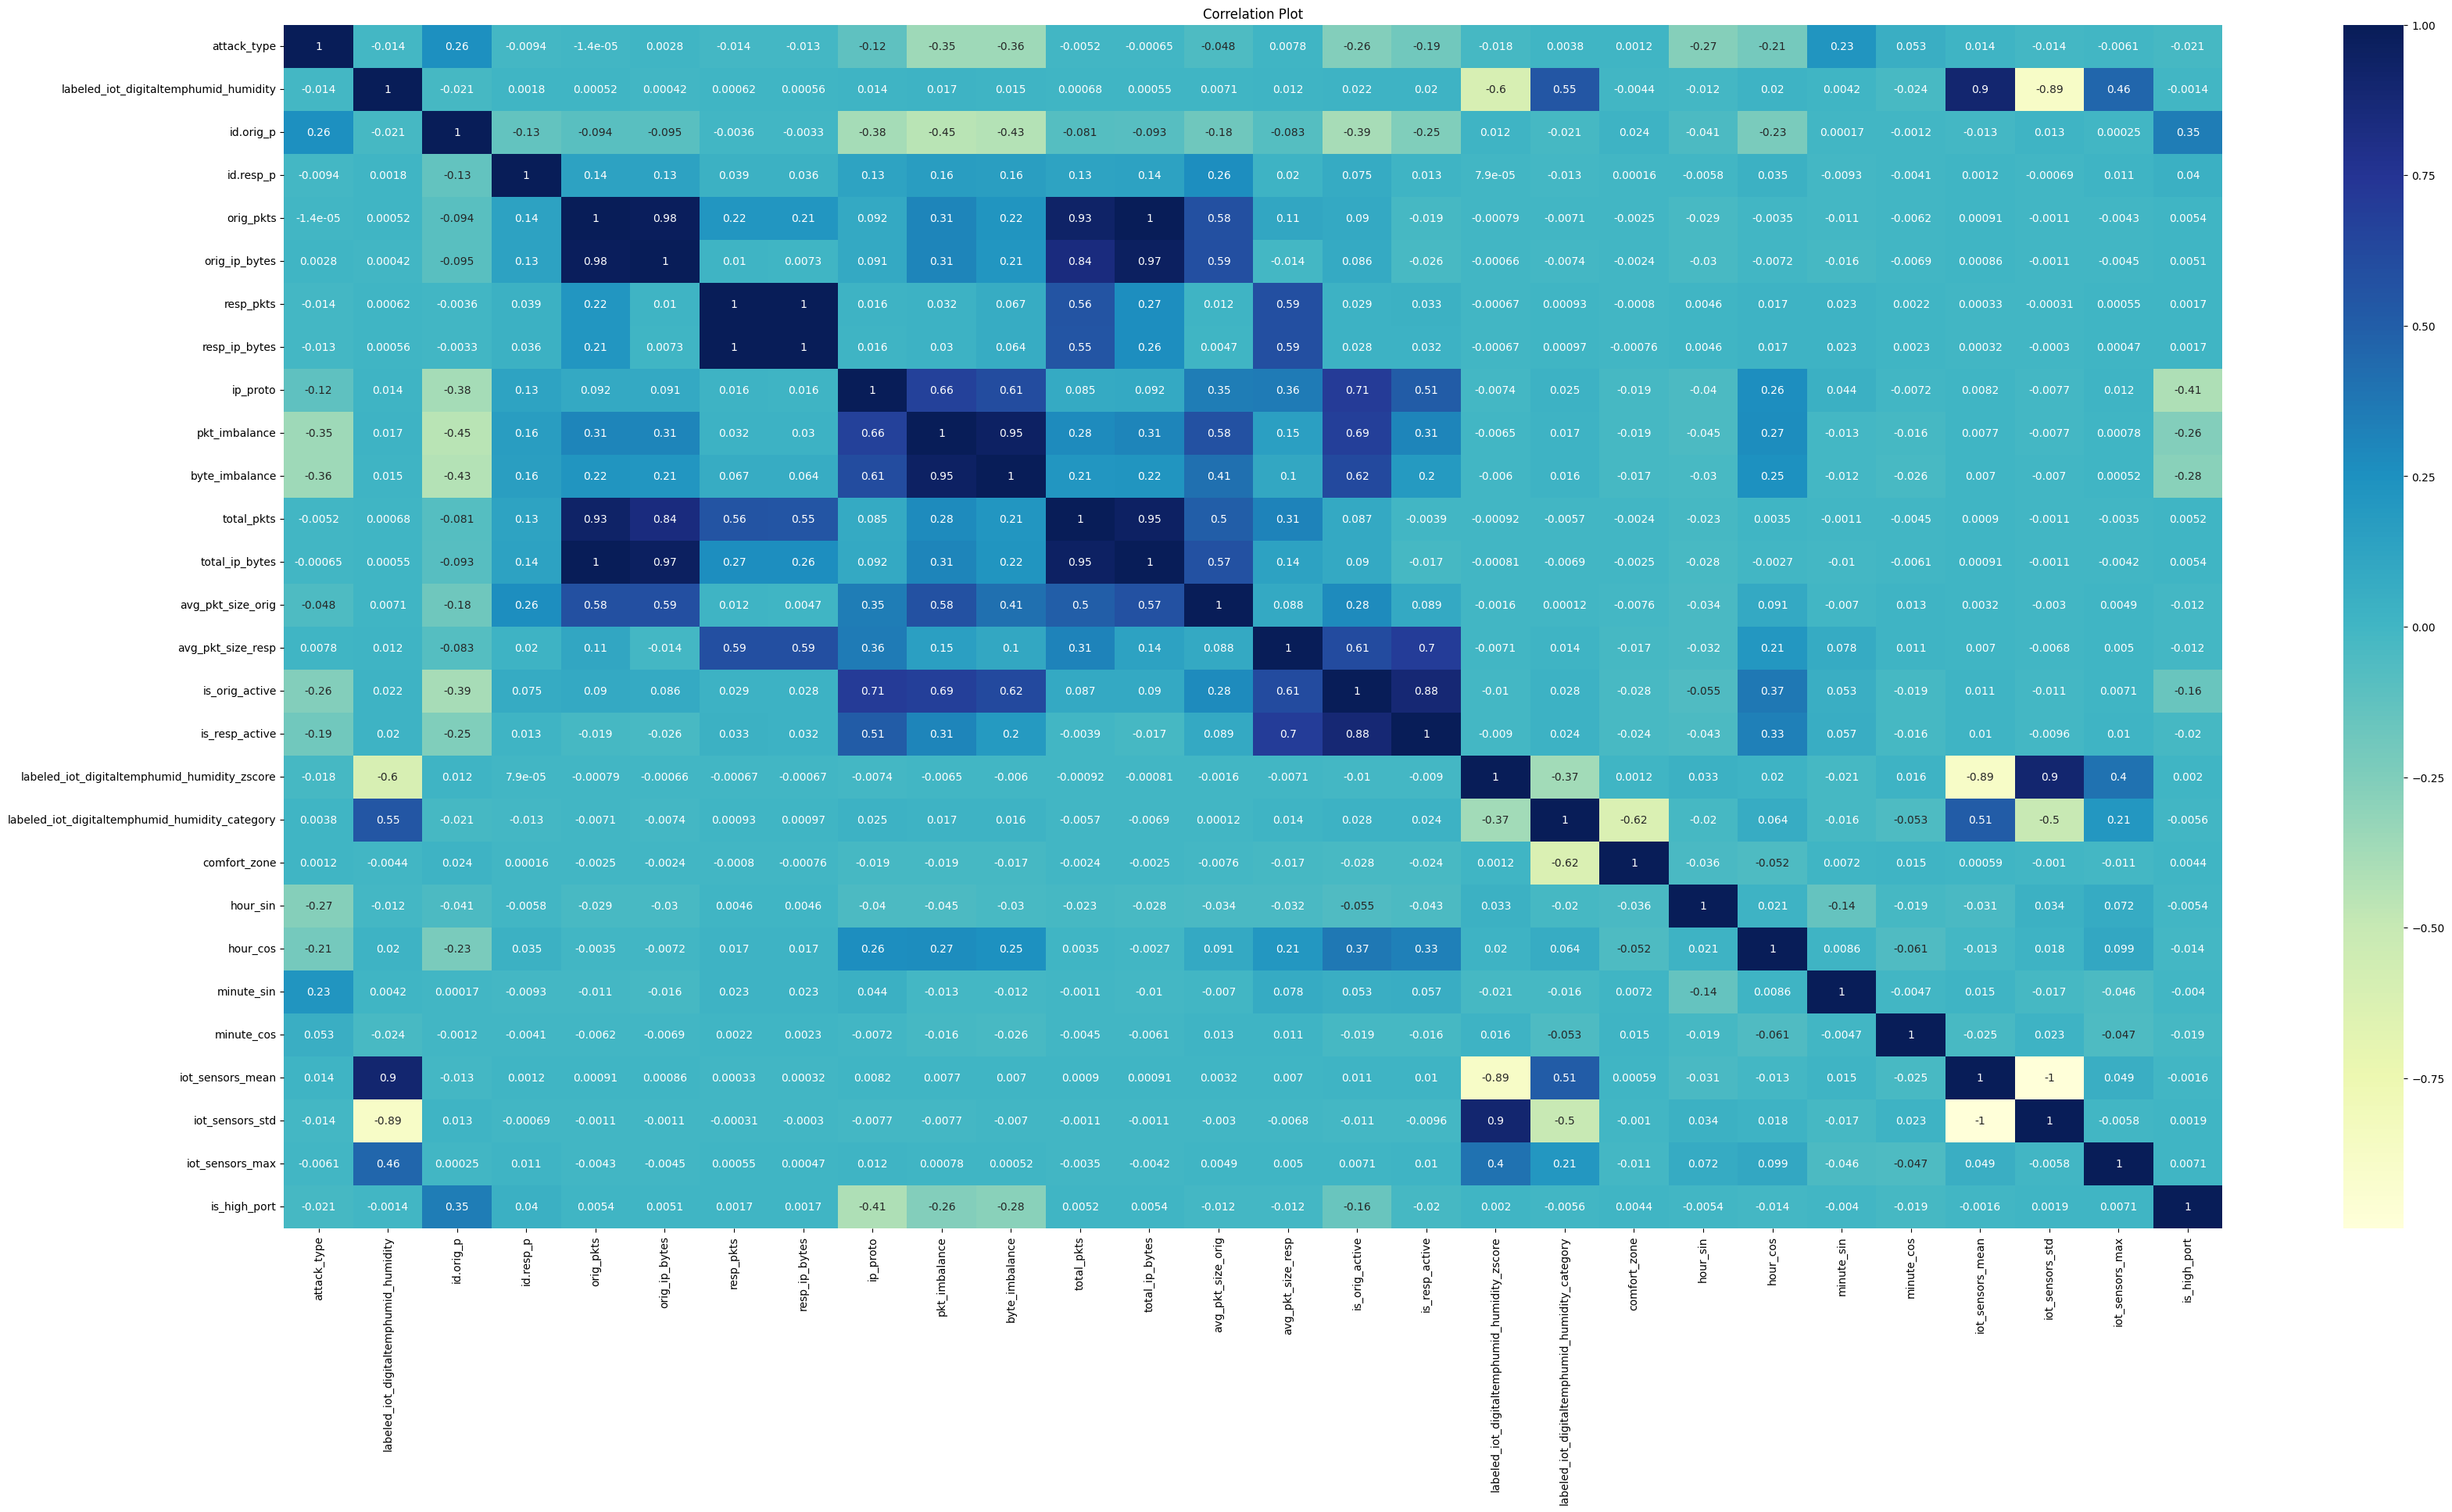

In [104]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(train_df.corr(),cmap='YlGnBu', annot=True)
plt.savefig("FeaturesCorrelationMatrix.png")

# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Print the highly correlated features
print("Highly correlated features:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")

In [105]:
# Create a set of features to drop
features_to_drop = set()

# Iterate over the highly correlated features and add one of each pair to the drop list
for feature1, feature2 in highly_correlated_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        # if feature1 != 'label' and feature2 != 'label': # Binary Classification
        if feature1 != 'attack_type' and feature2 != 'attack_type': # Multi-Class Classification
            features_to_drop.add(feature2)  # You can choose feature1 or feature2 to drop

# Drop the features from the DataFrame
train_df = train_df.drop(columns=features_to_drop)

# Print the remaining features
print("Remaining features after dropping highly correlated ones:")
print(train_df.columns)

Remaining features after dropping highly correlated ones:
Index(['attack_type', 'labeled_iot_digitaltemphumid_humidity', 'id.orig_p',
       'id.resp_p', 'orig_pkts', 'resp_pkts', 'ip_proto', 'pkt_imbalance',
       'avg_pkt_size_orig', 'avg_pkt_size_resp', 'is_orig_active',
       'labeled_iot_digitaltemphumid_humidity_zscore',
       'labeled_iot_digitaltemphumid_humidity_category', 'comfort_zone',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'iot_sensors_max',
       'is_high_port'],
      dtype='object')


In [106]:
# # Binary Classification
# x = train_df.drop(['label'], axis=1)
# y = train_df[['label']]

# Multi-Class Classification
x = train_df.drop(['attack_type'], axis=1)
y = train_df[['attack_type']]

print("Total features data: \n", x.count(),"\n")
print("Total target data: \n", y.count())
print()

Total features data: 
 labeled_iot_digitaltemphumid_humidity             20869
id.orig_p                                         20869
id.resp_p                                         20869
orig_pkts                                         20869
resp_pkts                                         20869
ip_proto                                          20869
pkt_imbalance                                     20869
avg_pkt_size_orig                                 20869
avg_pkt_size_resp                                 20869
is_orig_active                                    20869
labeled_iot_digitaltemphumid_humidity_zscore      20869
labeled_iot_digitaltemphumid_humidity_category    20869
comfort_zone                                      20869
hour_sin                                          20869
hour_cos                                          20869
minute_sin                                        20869
minute_cos                                        20869
iot_sensors_max          

In [107]:
# # Binary Classification
# print(train_df['label'].value_counts())

# Multi-Class Classification
print(train_df['attack_type'].value_counts())

attack_type
2    9088
3    4088
0    3204
1    2867
5    1227
4     395
Name: count, dtype: int64


In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20869 entries, 0 to 20868
Data columns (total 20 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   attack_type                                     20869 non-null  int64  
 1   labeled_iot_digitaltemphumid_humidity           20869 non-null  float64
 2   id.orig_p                                       20869 non-null  float64
 3   id.resp_p                                       20869 non-null  float64
 4   orig_pkts                                       20869 non-null  float64
 5   resp_pkts                                       20869 non-null  float64
 6   ip_proto                                        20869 non-null  float64
 7   pkt_imbalance                                   20869 non-null  float64
 8   avg_pkt_size_orig                               20869 non-null  float64
 9   avg_pkt_size_resp                      

**Mutual Information Scores**

In [109]:
# discrete_features = x.dtypes == int

# def mi_score_maker(x,y,discrete_features):
#     scores = mutual_info_regression(x,y,discrete_features=discrete_features)
#     df = pd.DataFrame({
#         'Features':x.columns,
#         'Scores':scores
#     })
#     df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
#     return df

# mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)

# mi_scores

In [110]:
# # Filter features with scores less than 0.01
# low_score_features = mi_scores[mi_scores['Scores'] < 0.01]

# # Extract the feature names
# low_score_feature_names = low_score_features['Features'].tolist()

# # Print the list of low score feature names
# low_score_feature_names

In [111]:
# plt.figure(figsize=(10, 8))

# # Create the barplot
# sns.barplot(x='Scores', y='Features', data=mi_scores)

# # Add a title
# plt.title("Mutual Information Scores", fontsize=16)

# # Rotate the y-axis labels (if needed)
# plt.yticks(rotation=0)

# # Rotate the x-axis labels (if needed)
# plt.xticks(rotation=45)

# # Display the plot
# plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
# plt.savefig("FeaturesMutualInformationScores.png")
# plt.show()

In [112]:
# x.drop(low_score_feature_names,axis=1, inplace = True)

In [113]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
print("Data scaled successfully. Shape:", x_scaled.shape)

Data scaled successfully. Shape: (20869, 19)


In [114]:
# # Binary Classification
# # Save X_scaled (assuming it's a NumPy array)
# pd.DataFrame(x_scaled).to_csv("x_scaled_binary_cfs_s.csv", index=False)

# # Save y_label (can be a NumPy array or Series)
# pd.DataFrame(y, columns=["label"]).to_csv("y_label_cfs_s.csv", index=False)
# print("All data saved as CSV:")
# print("- x_scaled -> 'x_scaled.csv'")
# print("- y -> 'y_label.csv'")


# Multi-Class Classification
# Save X_scaled (assuming it's a NumPy array)
pd.DataFrame(x_scaled).to_csv("x_scaled_multi_cfs_s.csv", index=False)

# Save y_type (can be a NumPy array or Series)
pd.DataFrame(y, columns=["attack_type"]).to_csv("y_type_cfs_s.csv", index=False)
print("All data saved as CSV:")
print("- x_scaled -> 'x_scaled.csv'")
print("- y -> 'y_type.csv'")

All data saved as CSV:
- x_scaled -> 'x_scaled.csv'
- y -> 'y_type.csv'
